# Erdio: Testing Classifiers

Testing audio classifiers for Project Erdio, an urban environmental sound classifier.

Team members (alphabetical order): Matthew Frick, Matthew Heffernan, Paul Jredini

Goal: Classify sounds for key stakeholders (see Stakeholder and KPI documentation).

In those notebook, we explore a variety of different classifiers in the quest for an optimal classifier. We also investigate feature selection.

## Setup: Load packages and define lists

In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

# Standard sklearn processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# sklearn Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier

## import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Define shortcuts for classifiers
names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "LDA",
    "ExtraTrees",
    "Boosted RF",
    #"GradientBoosting",
    "Stacking"
]

# Collect classifiers into an iterable
## All the hyperparameters are chosen for reasonable, albeit not tuned, performance.
classifiers = [
    make_pipeline(RobustScaler(), LogisticRegression(max_iter=10000, n_jobs=4)),
    make_pipeline(RobustScaler(), KNeighborsClassifier(5,n_jobs=4)),
    make_pipeline(RobustScaler(), DecisionTreeClassifier(max_depth=15)),
    make_pipeline(RobustScaler(), RandomForestClassifier(max_depth=15, n_estimators=500,n_jobs=4)),
    make_pipeline(RobustScaler(), MLPClassifier(hidden_layer_sizes=(150,150,150,150,150,), max_iter=100000, early_stopping=True)),
    make_pipeline(RobustScaler(), AdaBoostClassifier()),
    make_pipeline(RobustScaler(), GaussianNB()),
    make_pipeline(RobustScaler(), QuadraticDiscriminantAnalysis()),
    make_pipeline(RobustScaler(), LinearDiscriminantAnalysis()),
    make_pipeline(RobustScaler(), ExtraTreesClassifier(n_estimators=500, max_depth=15)),
    make_pipeline(RobustScaler(), AdaBoostClassifier(RandomForestClassifier(max_depth=15, n_estimators=500,n_jobs=4))),
    #make_pipeline(RobustScaler(), GradientBoostingClassifier()), # Large memory usage
    make_pipeline(RobustScaler(), StackingClassifier(estimators=[('LDA', make_pipeline(StandardScaler(),LinearDiscriminantAnalysis())),
    ('rf', RandomForestClassifier(max_depth=15,n_estimators=1000, random_state=42))], final_estimator=LogisticRegression(max_iter=5000)))
]

skip_scaling = False

if skip_scaling:
    
    classifiers = [
        LogisticRegression(max_iter=10000),
        KNeighborsClassifier(5,n_jobs=4),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        DecisionTreeClassifier(max_depth=15),
        RandomForestClassifier(max_depth=15, n_estimators=500,n_jobs=4),
        MLPClassifier(alpha=0.01, max_iter=1000,early_stopping=True),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis(),
        LinearDiscriminantAnalysis(),
        ExtraTreesClassifier(n_estimators=500, max_depth=15),
        AdaBoostClassifier(RandomForestClassifier(max_depth=15, n_estimators=500,n_jobs=4)),
        GradientBoostingClassifier(),
        StackingClassifier(estimators=[('LDA', make_pipeline(StandardScaler(),LinearDiscriminantAnalysis())),
        ('rf', RandomForestClassifier(max_depth=15,n_estimators=1000, random_state=42))
    ], final_estimator=LogisticRegression(max_iter=5000))
    ]

# Set plotting options
plt.style.use('dark_background')
%matplotlib inline

## Setup: Loading data, choosing features

In [2]:
# Define keys for classifier 

full_classify_keys = [
 'eq_0',
 'eq_10',
 'eq_20',
 'eq_30',
 'eq_40',
 'eq_60',
 'eq_80',
 'eq_120',
 'eq_160',
 'eq_230',
 'eq_300',
 'eq_450',
 'eq_600',
 'eq_900',
 'eq_1200',
 'eq_1800',
 'eq_2400',
 'eq_3700',
 'eq_5000',
 'eq_7500',
 'eq_10000',
 'eq_15000',
 'eq_20000',
 'crestfactor',
 #'salience', # We don't include this because it isn't in anything we can test on
 'harmonic_power',
 'percussive_power',
 'harmonic_hits',
 'percussive_hits',
 'power_ratio',
 'hits_ratio',
 'roll_32.spec_flatness.median',
 'roll_32.spec_flatness.iqr',
 'roll_32.spec_centroid.median',
 'roll_32.spec_bandwidth.median',
 'roll_32.spec_bandwidth.std',
 'roll_32.y_mw_zcr',
 'roll_64.spec_flatness.median',
 'roll_64.spec_flatness.iqr',
 'roll_64.spec_centroid.median',
 'roll_64.spec_bandwidth.median',
 'roll_64.spec_bandwidth.std',
 'roll_64.y_mw_zcr',
 'roll_128.spec_flatness.median',
 'roll_128.spec_flatness.iqr',
 'roll_128.spec_centroid.median',
 'roll_128.spec_bandwidth.median',
 'roll_128.spec_bandwidth.std',
 'roll_128.y_mw_zcr',
 'roll_64.logbands_mw_5.0',
 'roll_64.logbands_mw_5.1',
 'roll_64.logbands_mw_5.2',
 'roll_64.logbands_mw_5.3',
 'roll_64.logbands_mw_5.4',
 'roll_64.logbands_mw_10.0',
 'roll_64.logbands_mw_10.1',
 'roll_64.logbands_mw_10.2',
 'roll_64.logbands_mw_10.3',
 'roll_64.logbands_mw_10.4',
 'roll_64.logbands_mw_10.5',
 'roll_64.logbands_mw_10.6',
 'roll_64.logbands_mw_10.7',
 'roll_64.logbands_mw_10.8',
 'roll_64.logbands_mw_10.9',
 'roll_64.logbands_mw_20.0',
 'roll_64.logbands_mw_20.1',
 'roll_64.logbands_mw_20.2',
 'roll_64.logbands_mw_20.3',
 'roll_64.logbands_mw_20.4',
 'roll_64.logbands_mw_20.5',
 'roll_64.logbands_mw_20.6',
 'roll_64.logbands_mw_20.7',
 'roll_64.logbands_mw_20.8',
 'roll_64.logbands_mw_20.9',
 'roll_64.logbands_mw_20.10',
 'roll_64.logbands_mw_20.11',
 'roll_64.logbands_mw_20.12',
 'roll_64.logbands_mw_20.13',
 'roll_64.logbands_mw_20.14',
 'roll_64.logbands_mw_20.15',
 'roll_64.logbands_mw_20.16',
 'roll_64.logbands_mw_20.17',
 'roll_64.logbands_mw_20.18',
 'roll_64.logbands_mw_20.19']

In [3]:
# Only keys for the equalizer

eq_keys = [ 'eq_0',
 'eq_10',
 'eq_20',
 'eq_30',
 'eq_40',
 'eq_60',
 'eq_80',
 'eq_120',
 'eq_160',
 'eq_230',
 'eq_300',
 'eq_450',
 'eq_600',
 'eq_900',
 'eq_1200',
 'eq_1800',
 'eq_2400',
 'eq_3700',
 'eq_5000',
 'eq_7500',
 'eq_10000',
 'eq_15000',
 'eq_20000']

In [4]:
# Do some quick data pre-processing

eq_df = pd.read_csv('large_data/indexedfinal.csv') # unsorted Equalizer and musical features with bad eq values
eq_correction = pd.read_csv('./large_data/eq_only_corrected.csv') # Just corrected eq values
eq_correction.fillna(1e-16, inplace=True) # there's 1 NaN in there, because one of the vectors had 0 ultrasound elements. Replace by 1 so when we take log10, it's 0.
eq_df.sort_values(by="index", inplace=True, ignore_index=True) # sort the unsorted stuff based on the column labelled "index", replace in built index by sorted index

# Get eq values in the interval, labeled as "corrected"

eq_df['eq_0'] = eq_correction['eq_0']
eq_df['eq_10'] = eq_correction['eq_10']
eq_df['eq_20'] = eq_correction['eq_20'].replace(0,1e-16) # Set zeros to small number for regularization in log
eq_df['eq_30'] = eq_correction['eq_30']
eq_df['eq_40'] = eq_correction['eq_40']
eq_df['eq_60'] = eq_correction['eq_60']
eq_df['eq_80'] = eq_correction['eq_80']
eq_df['eq_120'] = eq_correction['eq_120']
eq_df['eq_160'] = eq_correction['eq_160']
eq_df['eq_230'] = eq_correction['eq_230']
eq_df['eq_300'] = eq_correction['eq_300']
eq_df['eq_450'] = eq_correction['eq_450']
eq_df['eq_600'] = eq_correction['eq_600']
eq_df['eq_900'] = eq_correction['eq_900']
eq_df['eq_1200'] = eq_correction['eq_1200']
eq_df['eq_1800'] = eq_correction['eq_1800']
eq_df['eq_2400'] = eq_correction['eq_2400']
eq_df['eq_3700'] = eq_correction['eq_3700']
eq_df['eq_5000'] = eq_correction['eq_5000']
eq_df['eq_7500'] = eq_correction['eq_7500']
eq_df['eq_10000'] = eq_correction['eq_10000']
eq_df['eq_15000'] = eq_correction['eq_15000']
eq_df['eq_20000'] = eq_correction['eq_20000']
eq_df.drop(columns='index',inplace=True)



In [5]:
# Load data

features_equalizer = eq_df.copy() # Equalizer and musical features
features = pd.read_csv('large_data/engineered_features_full1.csv', index_col=0) # Additional features
features_f0 = pd.read_csv('large_data/engineered_features_f0_full1.csv', index_col=0) # Addiitonal features

In [7]:
# Combine features into a single dataframe
features_df = pd.concat([features_equalizer, features, features_f0], axis=1)

In [8]:
# Scaling equalizer keys to bring them onto a more comparable scale

for eq in eq_keys:
    features_df[eq] = np.log10(features_df[eq])

In [9]:
# Define power and hits ratios between percussive and harmonic features

features_df['power_ratio'] = np.log10(features_df['percussive_power'].values / (features_df['harmonic_power'].values))
features_df['hits_ratio'] = np.log10(features_df['percussive_hits'].values / (features_df['harmonic_hits'].values + 1e-1) + 5e-4)

In [10]:
# Look at the data to make sure everything got loaded in.
# Errors become very obvious in .describe()
features_df.describe()

eq_0        eq_10        eq_20        eq_30        eq_40  \
count  8732.000000  8732.000000  8732.000000  8732.000000  8732.000000   
mean      0.785337     0.916040     1.051539     1.132848     1.302579   
std       0.935234     0.952378     1.013621     0.921144     0.853852   
min      -3.364845    -3.207380   -16.000000   -16.000000    -3.107313   
25%       0.239100     0.364115     0.529921     0.634888     0.822958   
50%       0.837194     0.963255     1.125729     1.212560     1.423087   
75%       1.419438     1.575761     1.726266     1.784629     1.934194   
max       3.549806     3.219022     3.439884     3.422457     3.303712   

             eq_60        eq_80       eq_120       eq_160       eq_230  ...  \
count  8732.000000  8732.000000  8732.000000  8732.000000  8732.000000  ...   
mean      1.357627     1.365340     1.363657     1.357052     1.326963  ...   
std       0.804929     0.735746     0.721130     0.706234     0.668150  ...   
min      -3.179078    -2.975943    -2.644454    -2.357084    -2.293734  ...   
25%       0.875727     0.922733     0.929785     0.915930     0.901075  ...   
50%       1.456911     1.486562     1.454012     1.430314     1.398805  ...   
75%       1.947067     1.900201     1.871600     1.882913     1.829999  ...   
max       3.400025     3.204518     3.285884     3.183056     3.032533  ...   

       range_high.f0_stats.f0_min  range_high.f0_signal  \
count                 6372.000000           8732.000000   
mean                  1103.624678              0.411027   
std                   1495.181558              0.362974   
min                    523.251131              0.000000   
25%                    523.251131              0.000000   
50%                    523.251131              0.364162   
75%                    744.275557              0.757225   
max                   8040.259669              0.994220   

       range_low.f0_stats.f0_mean  range_low.f0_stats.f0_median  \
count                 6153.000000                   6153.000000   
mean                   407.557234                    405.344046   
std                    488.222531                    494.152942   
min                     65.406391                     65.406391   
25%                     72.582150                     71.326176   
50%                    110.644597                    105.641024   
75%                    594.437367                    583.946767   
max                   2086.988685                   2093.004522   

       range_low.f0_stats.f0_std  range_low.f0_stats.f0_iqr  \
count                6153.000000                6153.000000   
mean                   57.728063                  84.702441   
std                   101.585604                 177.640426   
min                     0.000000                   0.000000   
25%                     3.876392                   2.823342   
50%                     9.832948                  11.462293   
75%                    61.613479                  70.170440   
max                   959.633231                1944.658526   

       range_low.f0_stats.f0_max  range_low.f0_stats.f0_min  power_ratio  \
count                6153.000000                6153.000000  8732.000000   
mean                  508.987818                 317.205632    -0.995106   
std                   592.026303                 414.434577     2.274398   
min                    65.406391                  65.406391    -7.160499   
25%                    86.304251                  65.406391    -2.398749   
50%                   133.870387                  79.599808    -1.150139   
75%                   770.522378                 440.000000    -0.037105   
max                  2093.004522                2080.949703    10.470580   

        hits_ratio  
count  8732.000000  
mean     -1.640759  
std       1.034565  
min      -3.301030  
25%      -2.303590  
50%      -1.510981  
75%      -0.946498  
max       2.466889  

[8 rows x 406 columns]

In [11]:
# Try grouping sounds into families of interest
# No improvement found, but code is left in place for future work.

# features_df['family'] = features_df['class'].replace({'air_conditioner':0, 'car_horn':0, 'children_playing':0, 'dog_bark':0, 'drilling':0, 'engine_idling':0, 'gun_shot':1, 'jackhammer':0, 'siren':0, 'street_music':0},inplace=False)
# familylabels = {'not gunshot':0, 'gunshot':1}.keys()

In [12]:
# Encode classes into numerical values
features_df.replace({'air_conditioner':0, 'car_horn':1, 'children_playing':2, 'dog_bark':3, 'drilling':4,
                'engine_idling':5, 'gun_shot':6, 'jackhammer':7, 'siren':8, 'street_music':9},inplace=True)

In [13]:
# Get a list of classes 
classlabels = {'air_conditioner':0, 'car_horn':1, 'children_playing':2, 
               'dog_bark':3, 'drilling':4, 'engine_idling':5, 
               'gun_shot':6, 'jackhammer':7, 'siren':8, 'street_music':9}.keys()

In [14]:
# Output features dataframe 

save = False
if save:
    features_df.to_csv('features_df.csv')

In [15]:
# Searching for NaNs in input to ensure data is clean
np.where(np.isnan(features_df[full_classify_keys].values) == 1)

(array([], dtype=int64), array([], dtype=int64))

Now that the data has been loaded, we drop a pre-determined fold as recommended by the data source.

In [16]:
# Drop fold and perform cross-validation split

dropfold = 3

cv_features_df = features_df.drop(features_df[features_df['fold']==dropfold].index)
cv_features_df.drop(columns='fold',inplace=True)

validation_features_df = features_df.drop(features_df[features_df['fold']!=dropfold].index)
validation_features_df.drop(columns='fold',inplace=True)

In [17]:
cv_features_df.head()

class      eq_0     eq_10     eq_20     eq_30     eq_40     eq_60  \
0      3 -1.375995 -1.494469 -1.451719 -1.281426 -0.658946 -0.689535   
1      2  0.856480  0.821880  0.997462  0.783837  0.912475  0.721754   
2      2  0.819386  0.792283  0.720321  0.789714  0.724272  0.727021   
3      2  0.772997  0.642017  0.714451  0.829689  0.603400  0.852557   
4      2  0.931373  0.637854  0.799281  1.071200  0.785805  0.841281   

      eq_80    eq_120    eq_160  ...  range_high.f0_stats.f0_min  \
0 -0.606677 -0.516618 -0.041881  ...                  544.841599   
1  0.758189  0.456822  0.275369  ...                 2080.949703   
2  0.766071  0.408717  0.278678  ...                 1077.167118   
3  0.792330  0.878636  0.348520  ...                  523.251131   
4  0.746758  0.589374  0.427006  ...                 2057.047957   

   range_high.f0_signal  range_low.f0_stats.f0_mean  \
0              0.571429                         NaN   
1              0.109827                         NaN   
2              0.294798                 1128.712229   
3              0.260116                         NaN   
4              0.156069                   66.850514   

   range_low.f0_stats.f0_median  range_low.f0_stats.f0_std  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                   1115.153334                  36.960305   
3                           NaN                        NaN   
4                     65.785287                   1.875716   

   range_low.f0_stats.f0_iqr  range_low.f0_stats.f0_max  \
0                        NaN                        NaN   
1                        NaN                        NaN   
2                  57.225801                1195.191751   
3                        NaN                        NaN   
4                   1.731598                  70.915367   

   range_low.f0_stats.f0_min  power_ratio  hits_ratio  
0                        NaN     2.725290   -1.055247  
1                        NaN     0.553428   -3.301030  
2                1077.167118    -1.699984   -1.630523  
3                        NaN     0.889862   -1.567587  
4                  65.406391    -1.688568   -3.301030  

[5 rows x 406 columns]

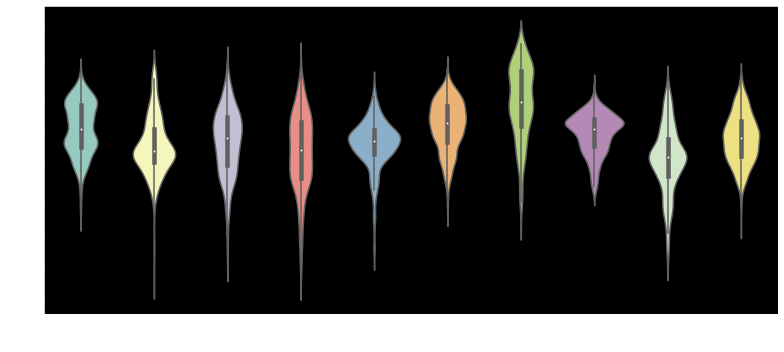

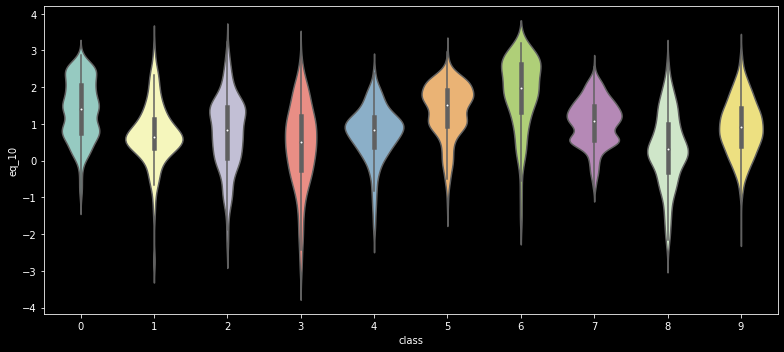

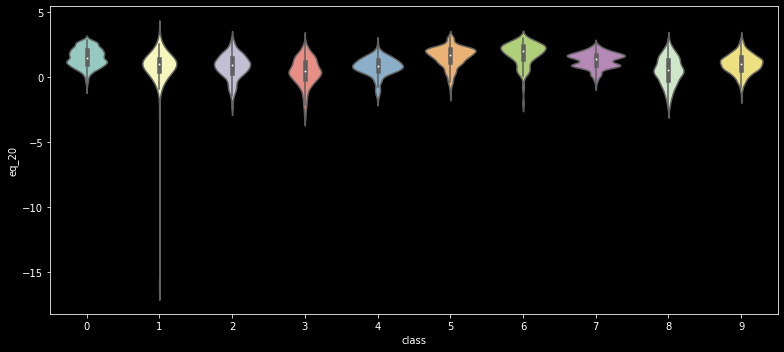

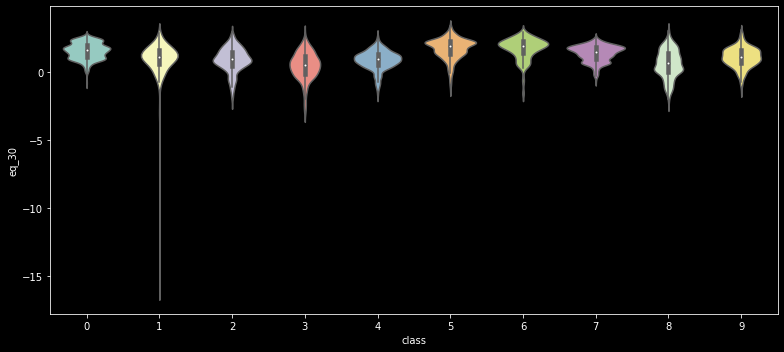

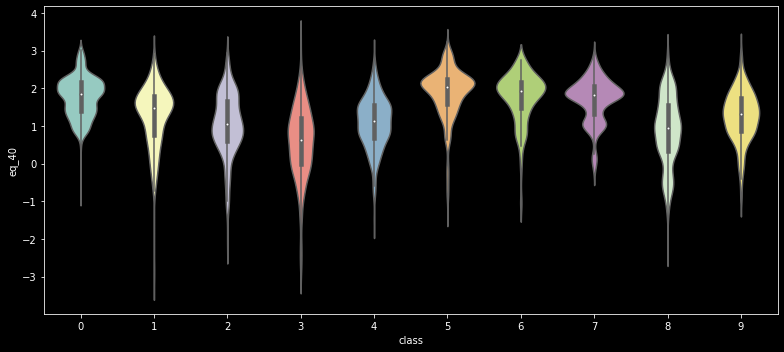

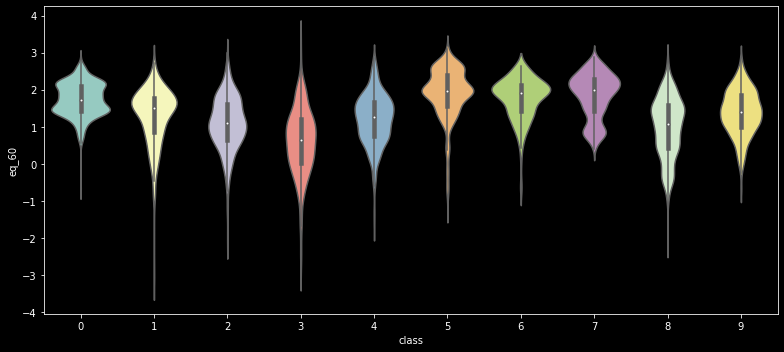

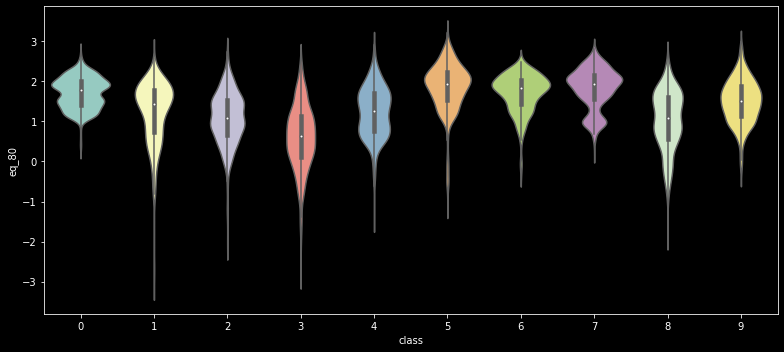

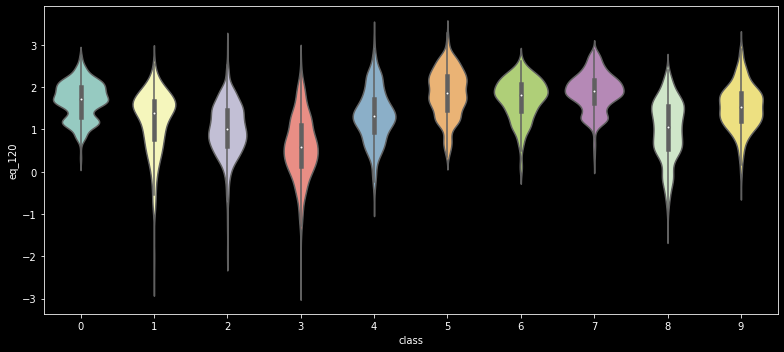

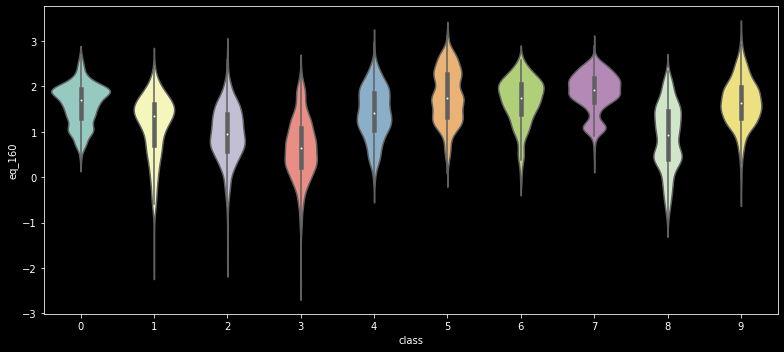

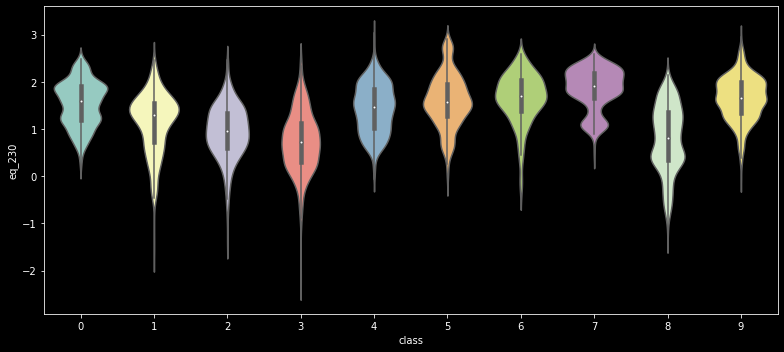

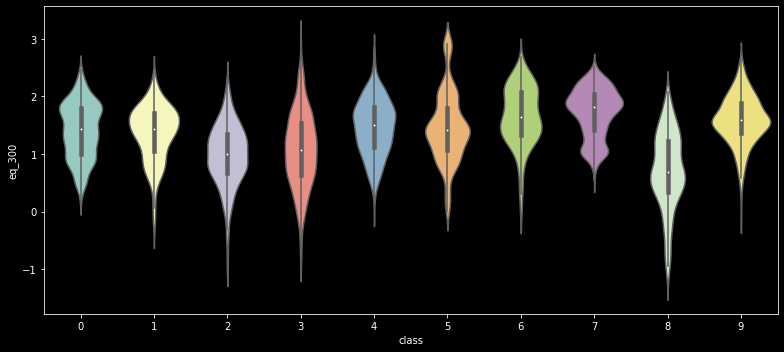

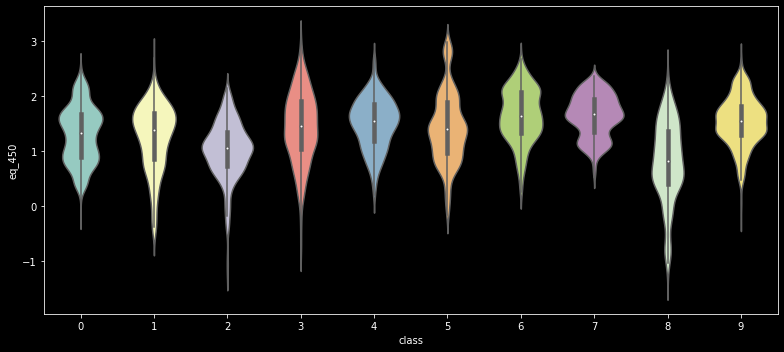

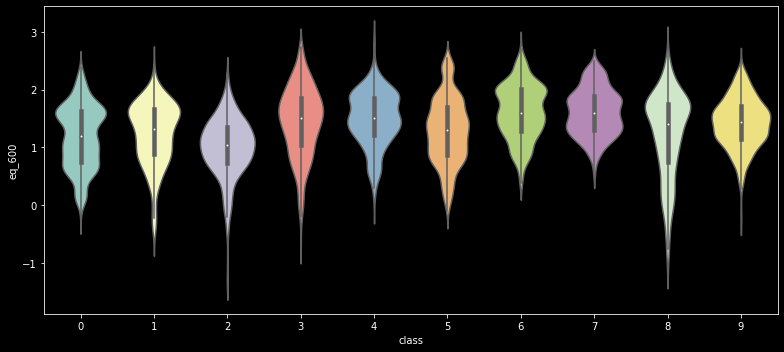

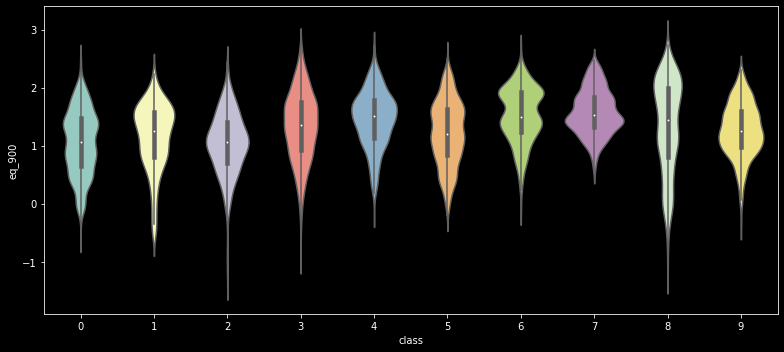

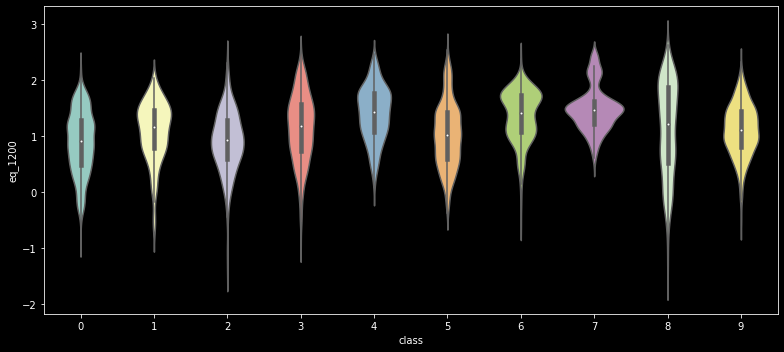

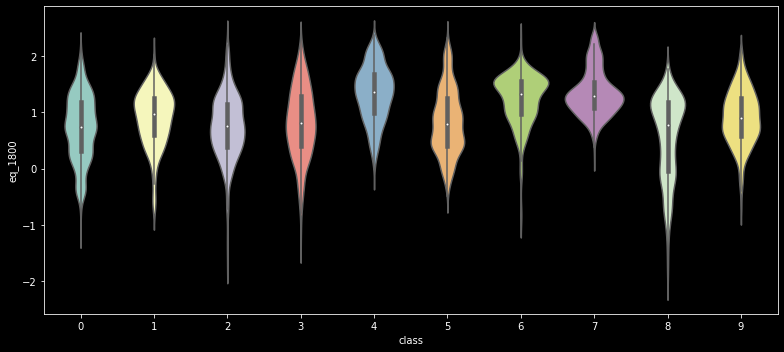

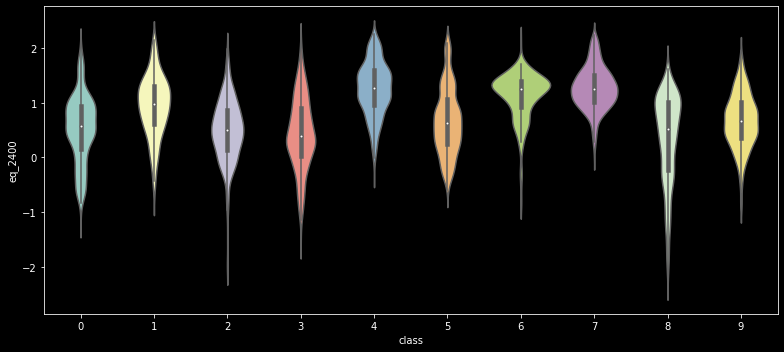

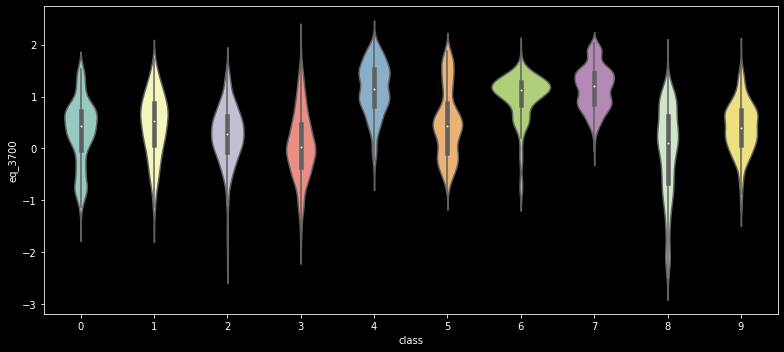

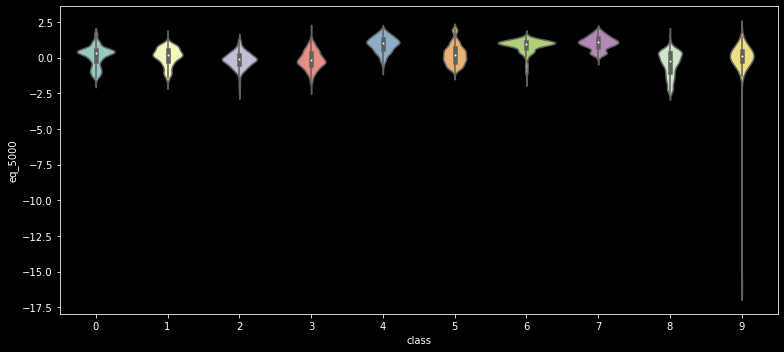

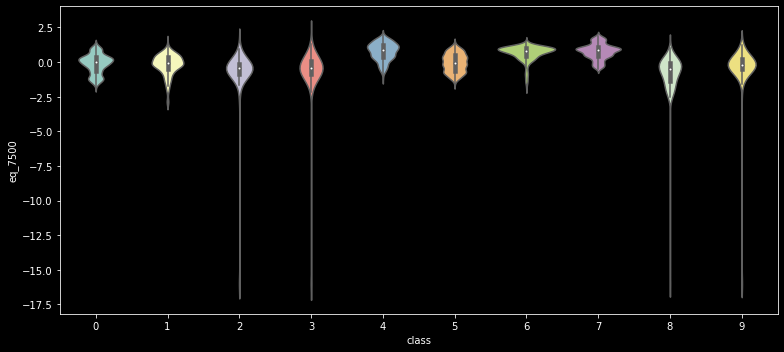

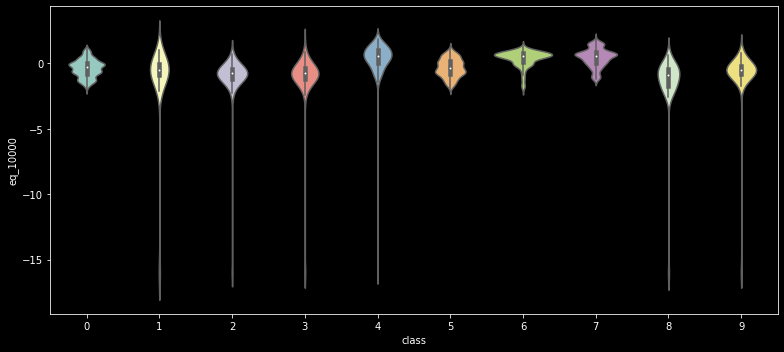

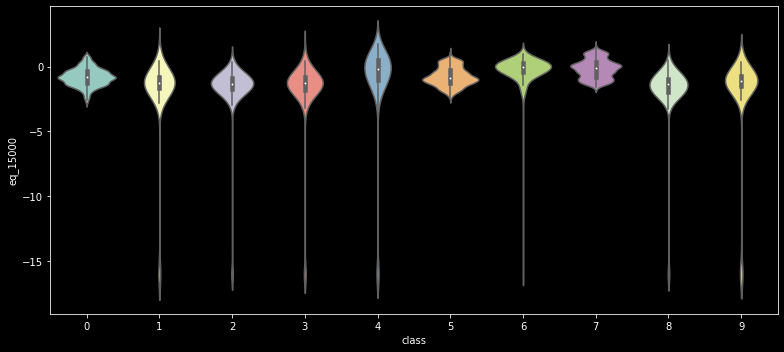

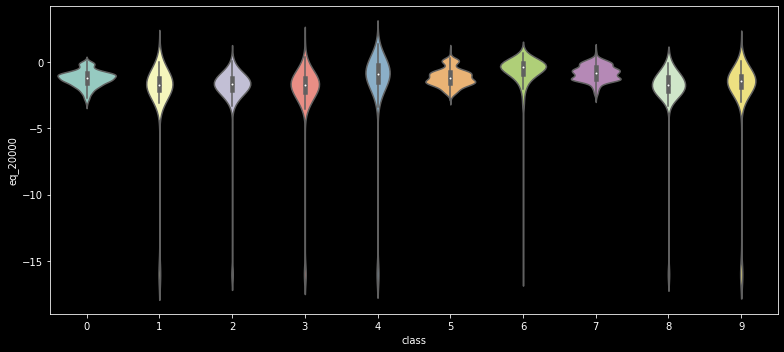

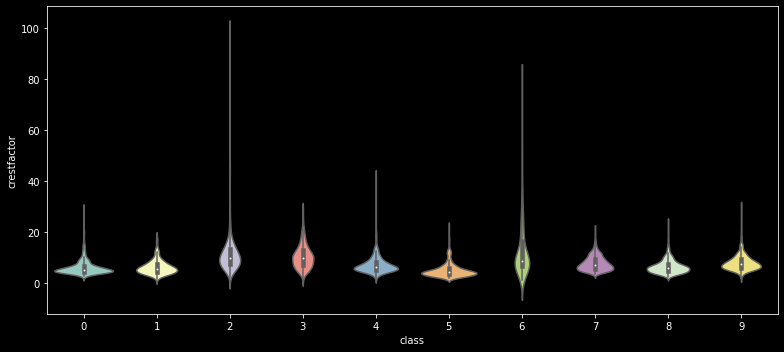

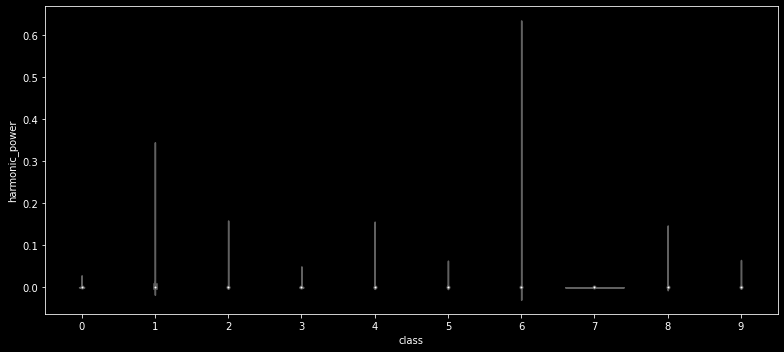

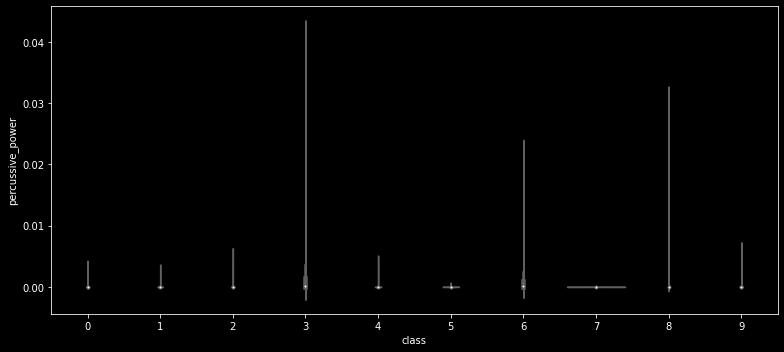

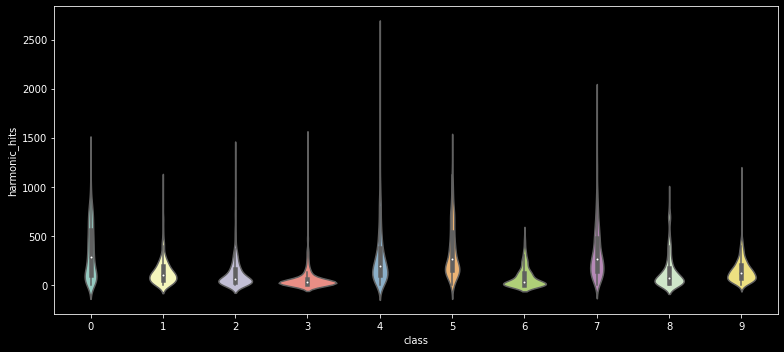

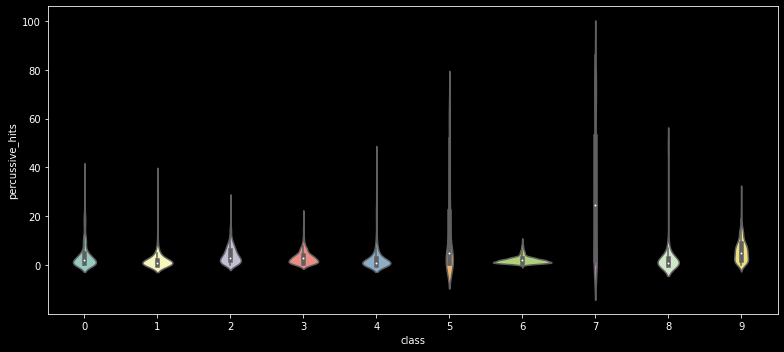

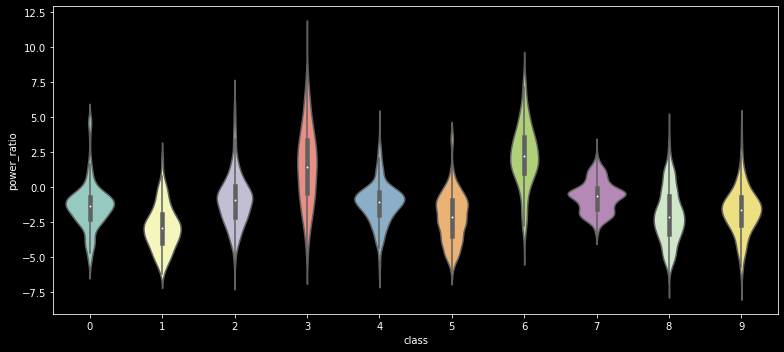

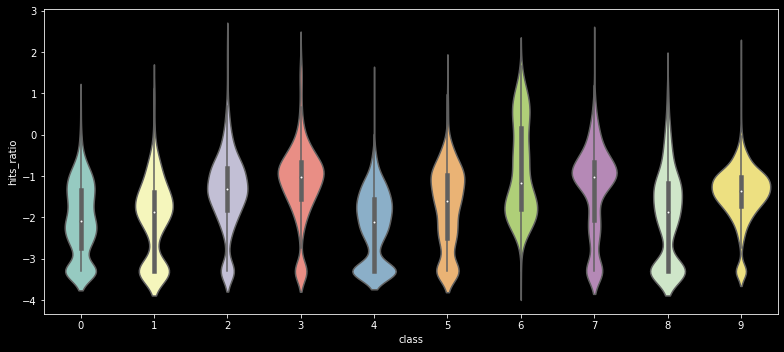

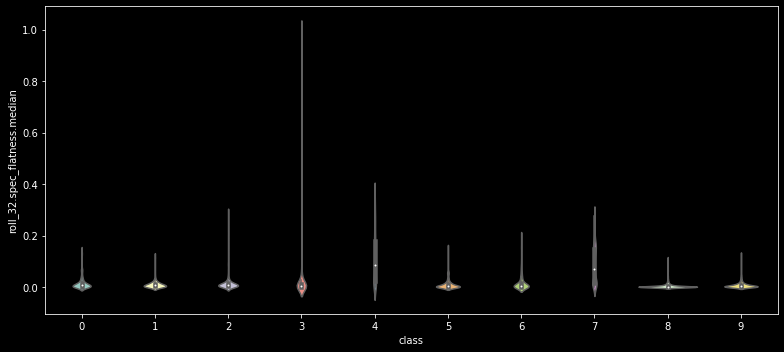

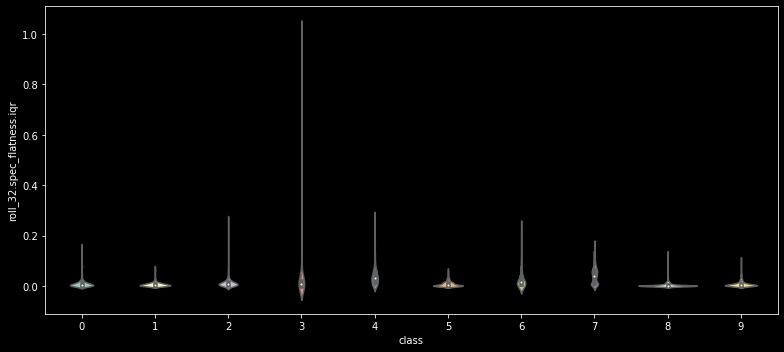

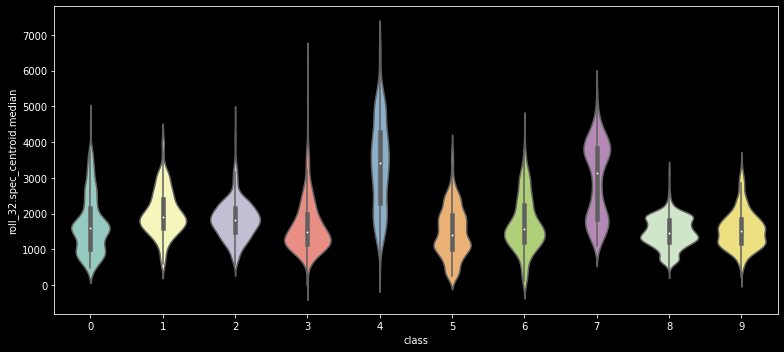

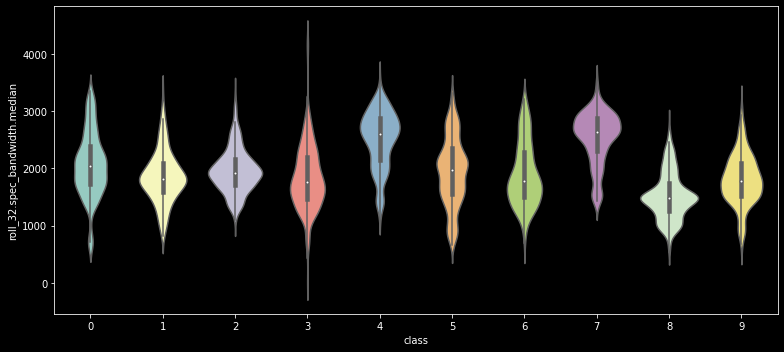

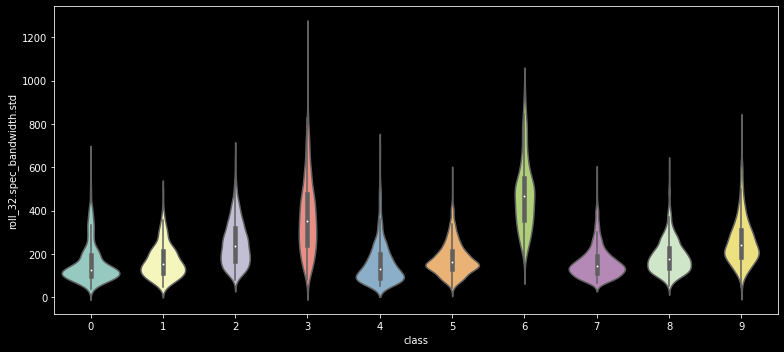

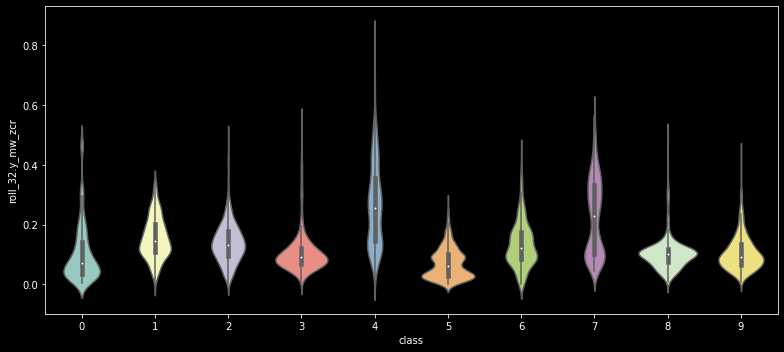

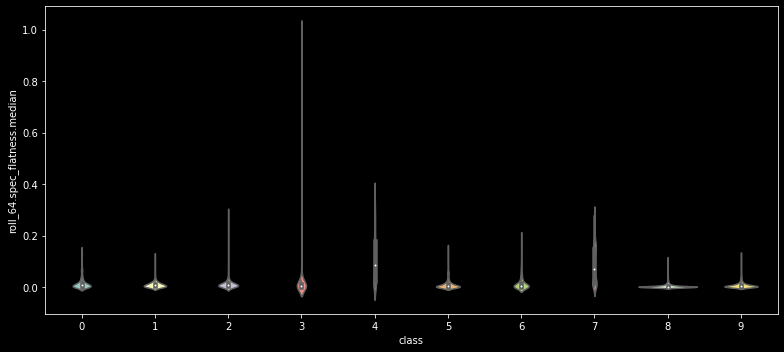

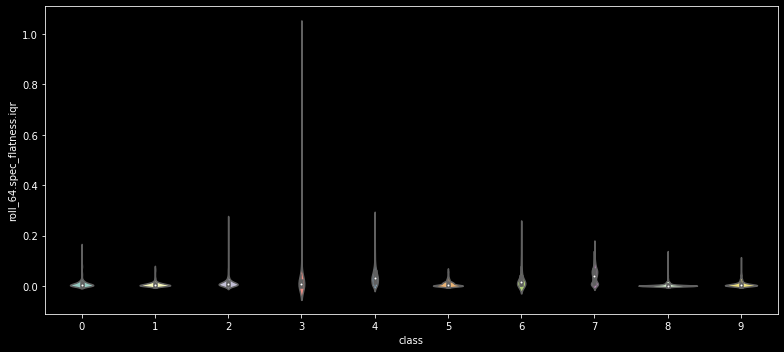

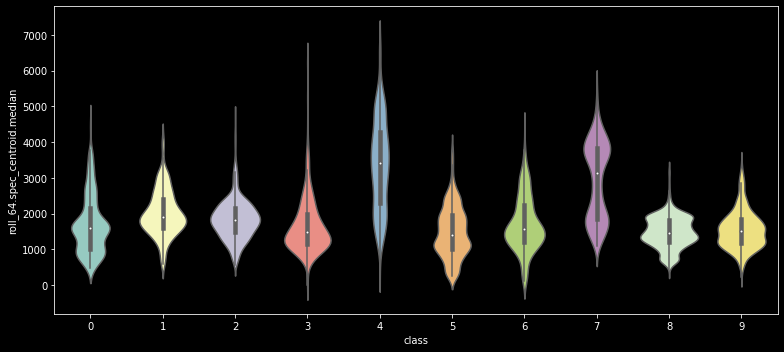

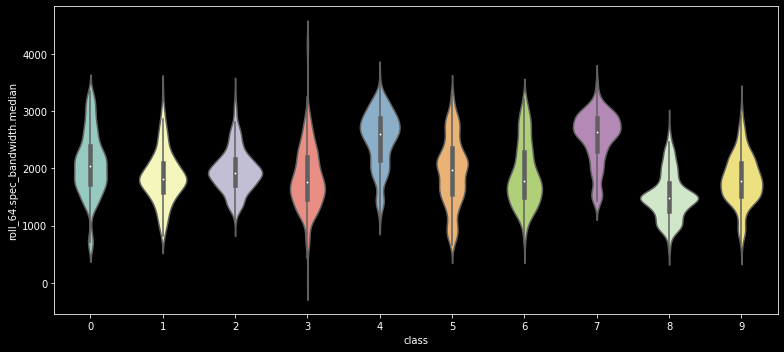

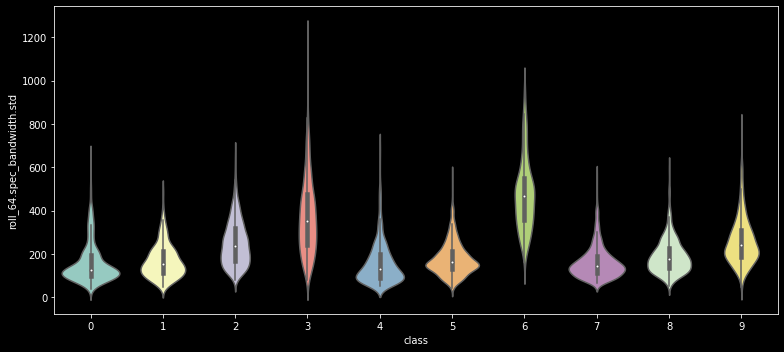

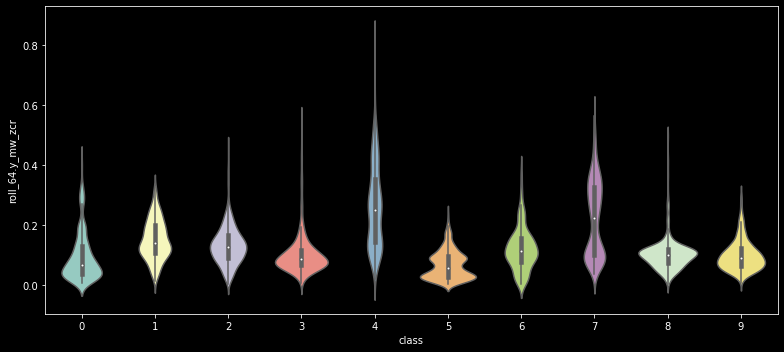

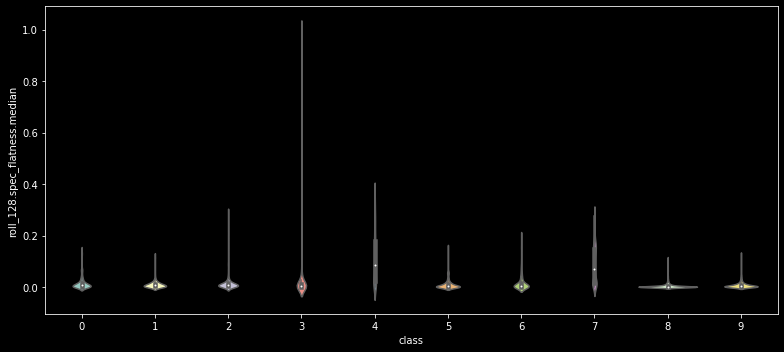

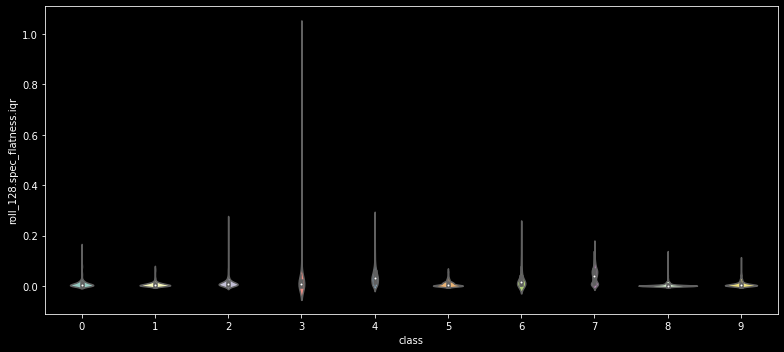

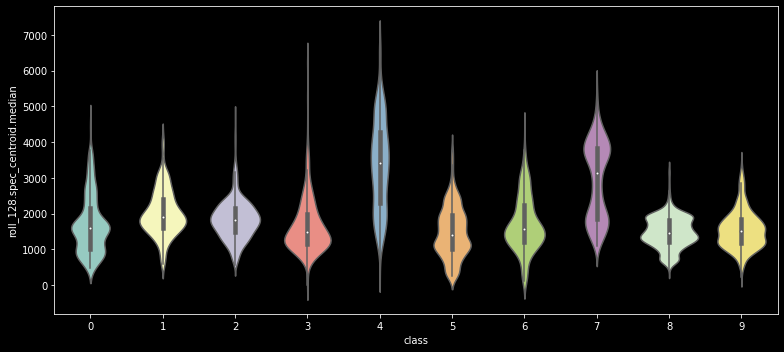

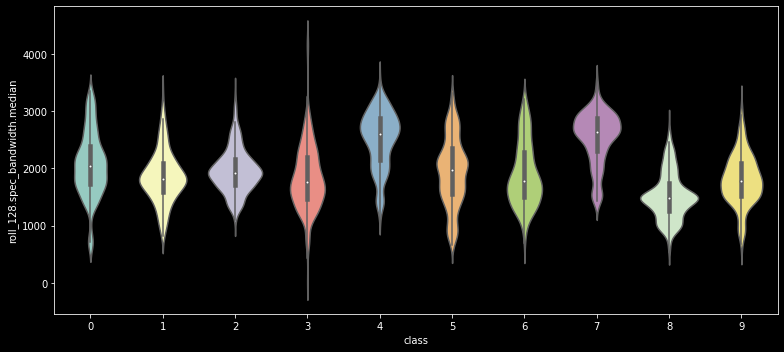

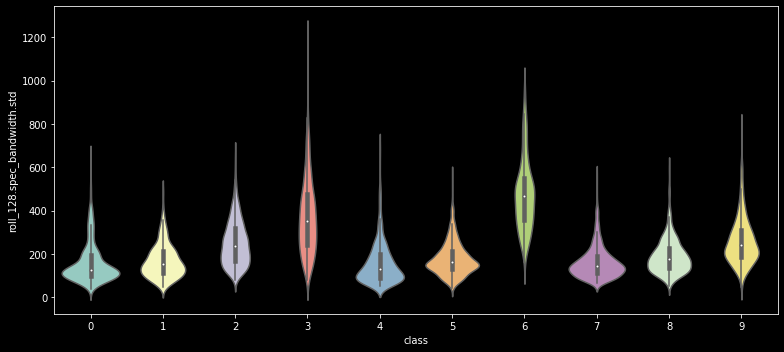

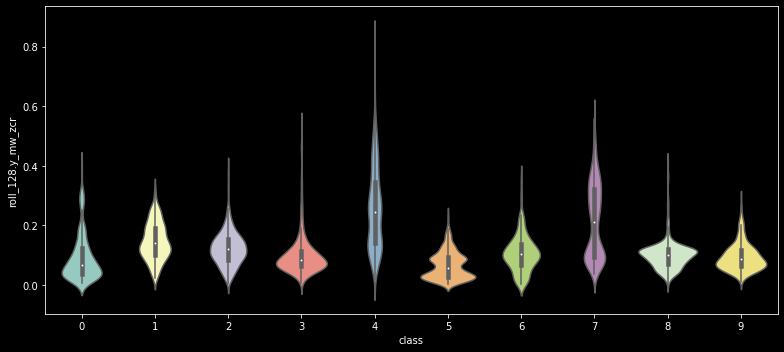

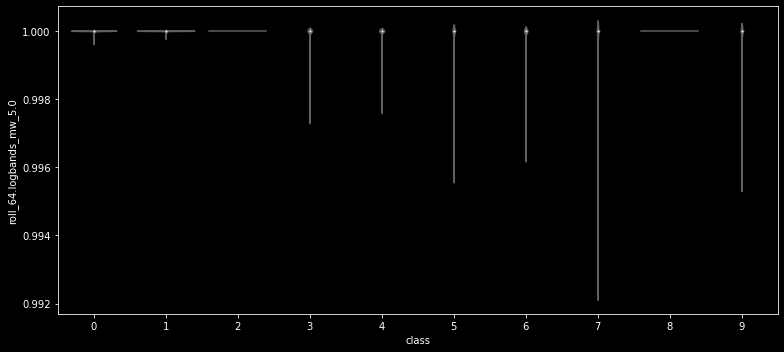

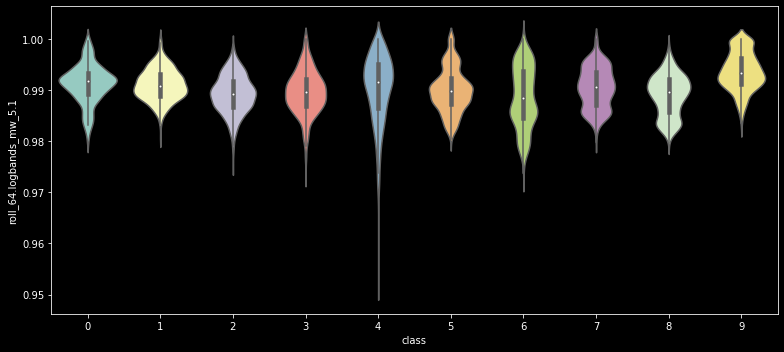

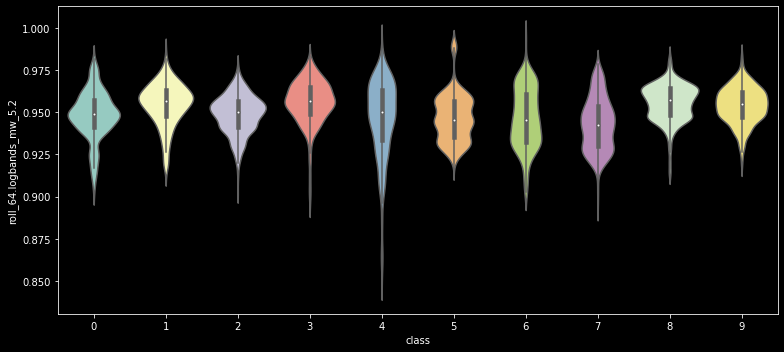

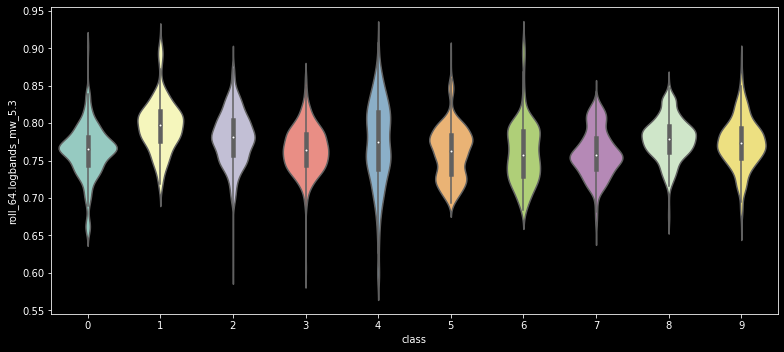

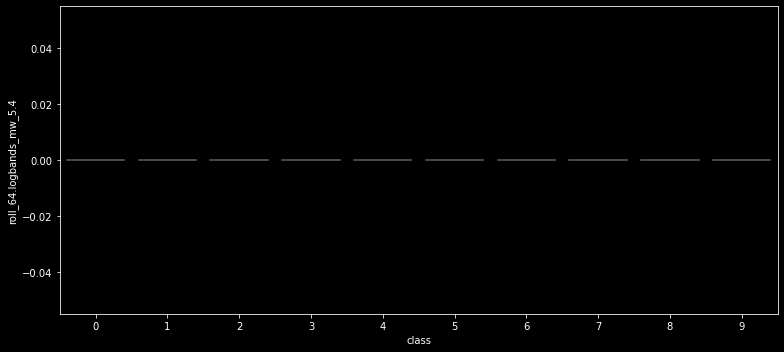

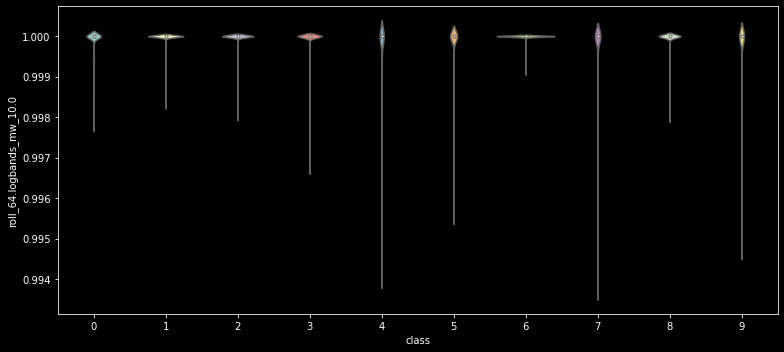

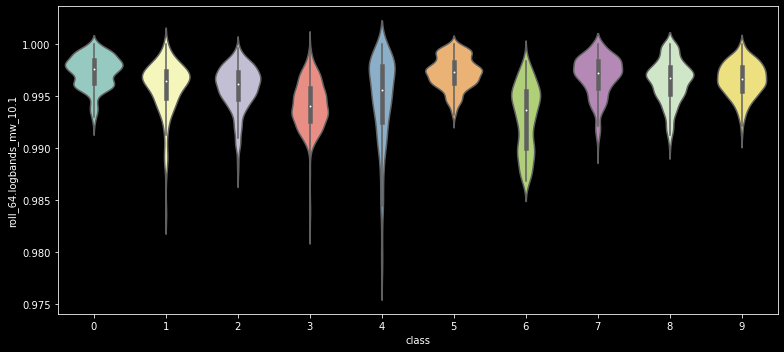

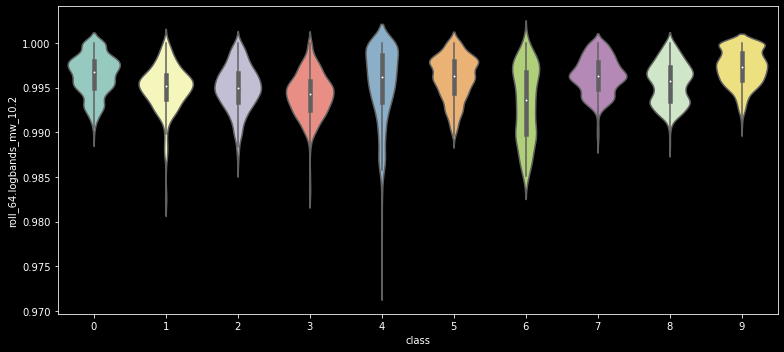

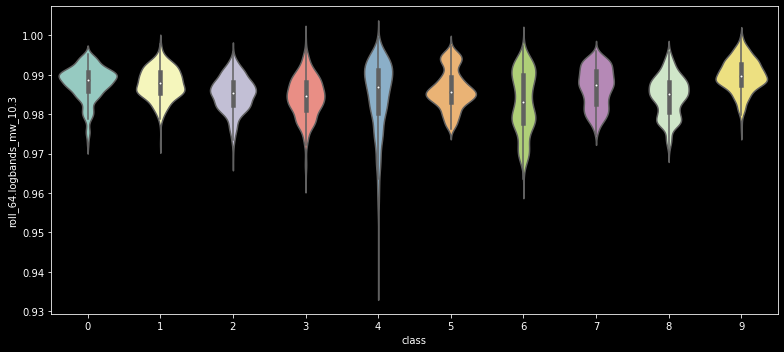

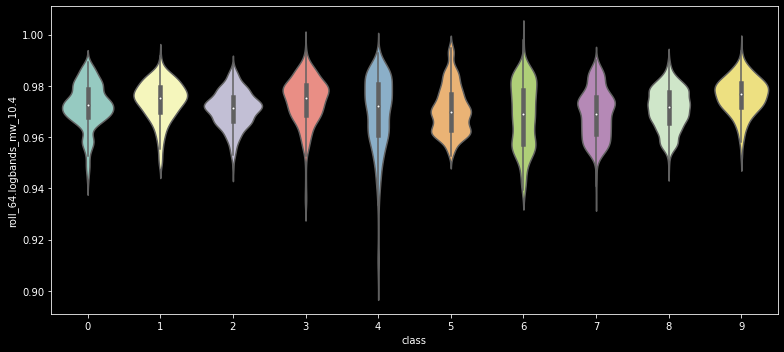

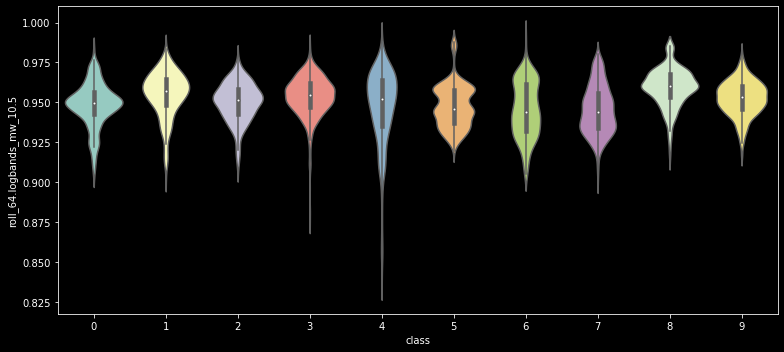

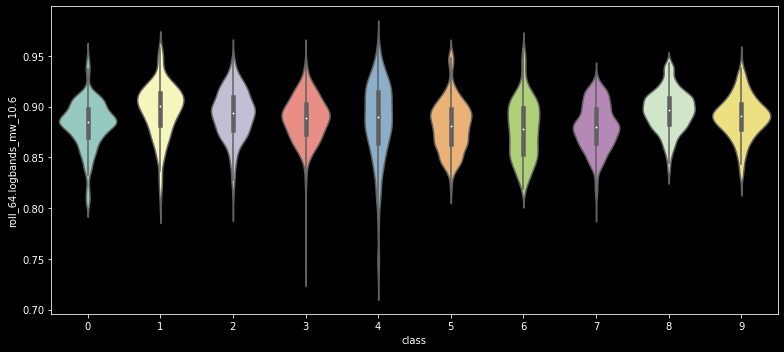

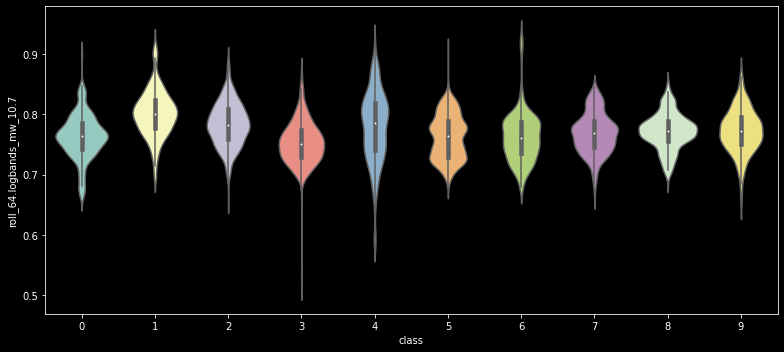

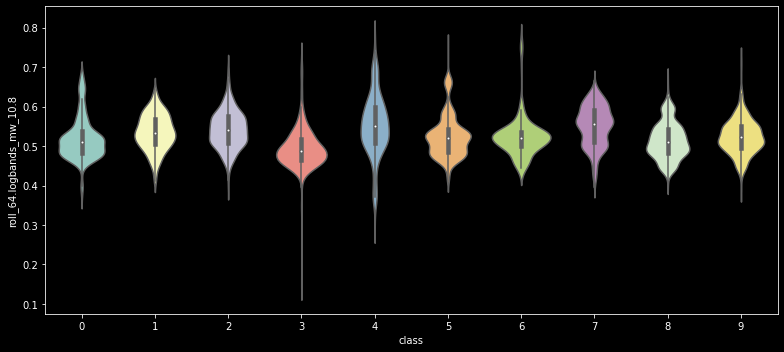

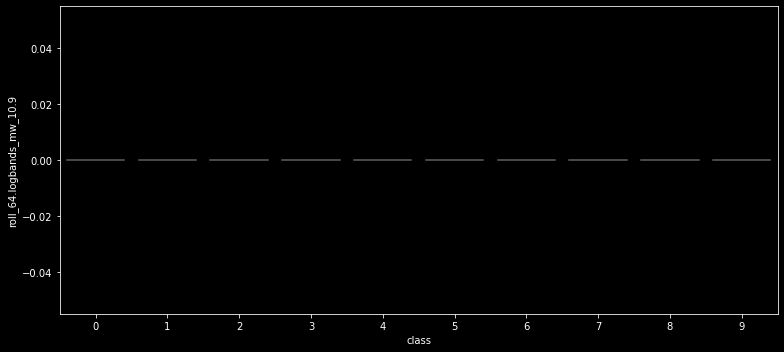

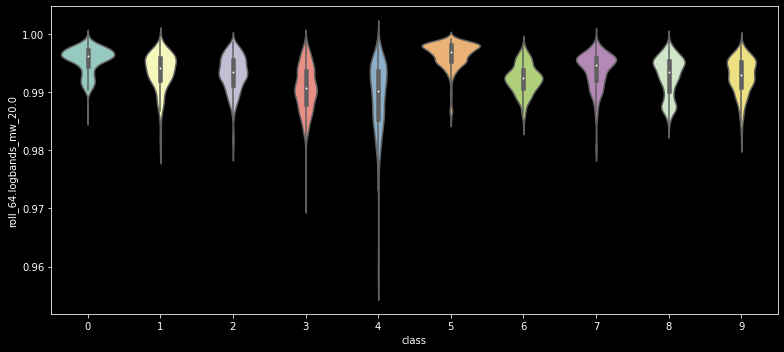

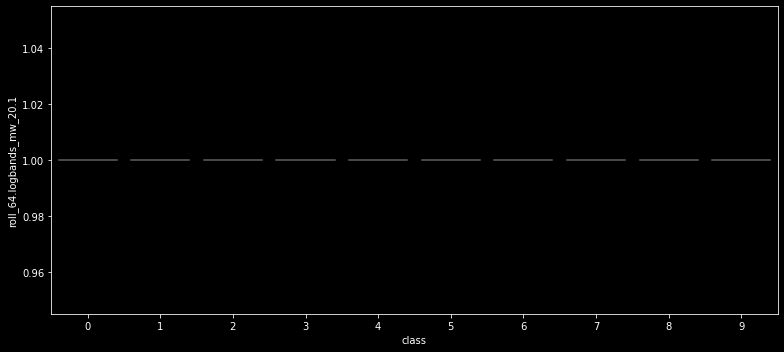

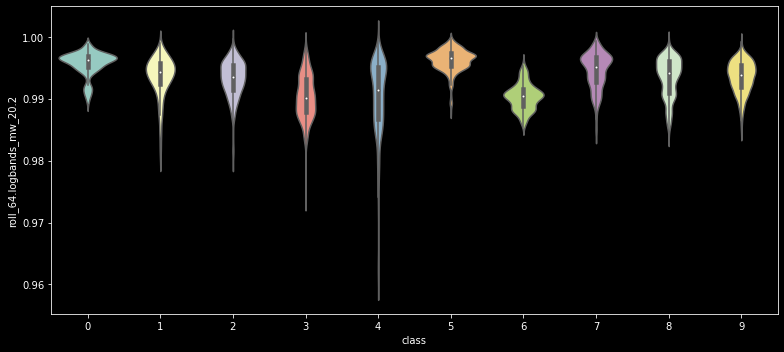

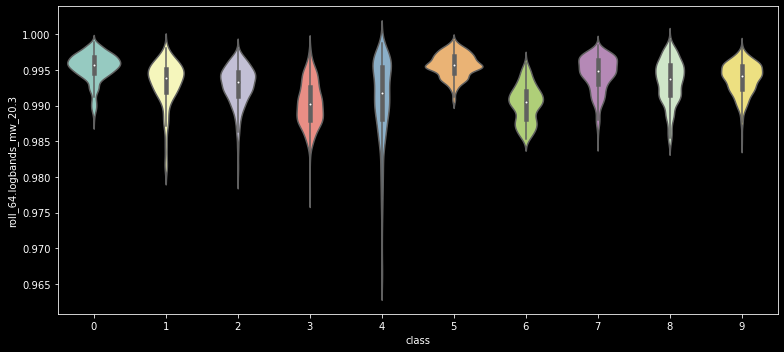

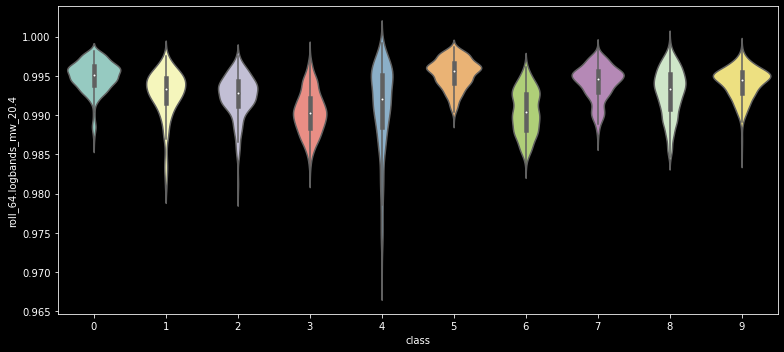

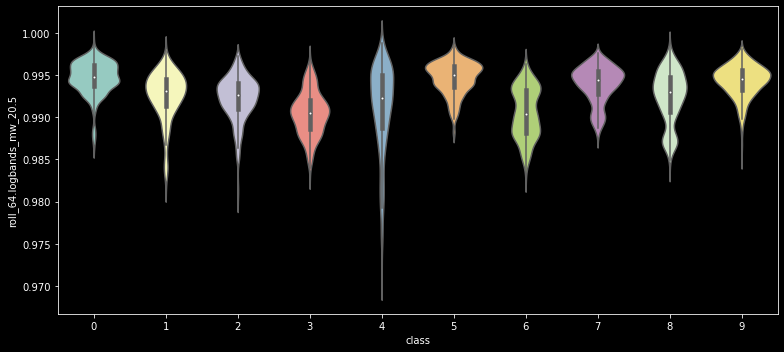

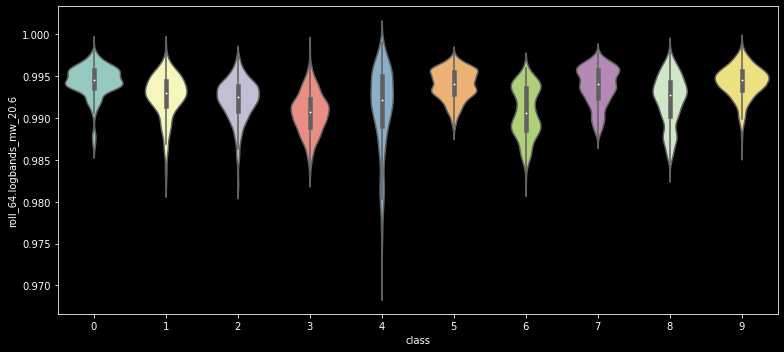

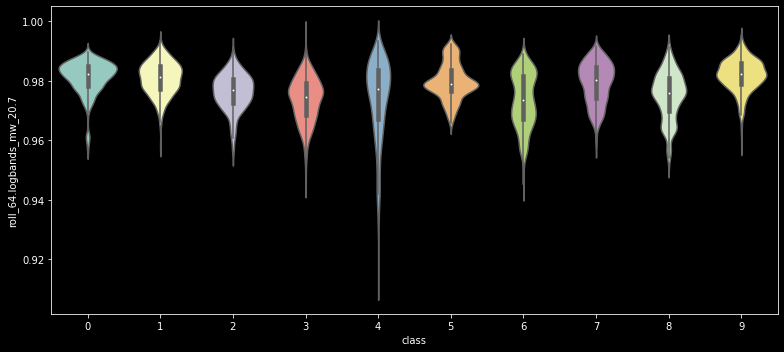

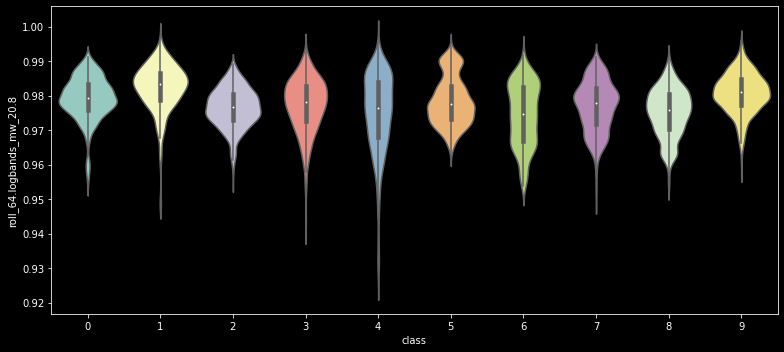

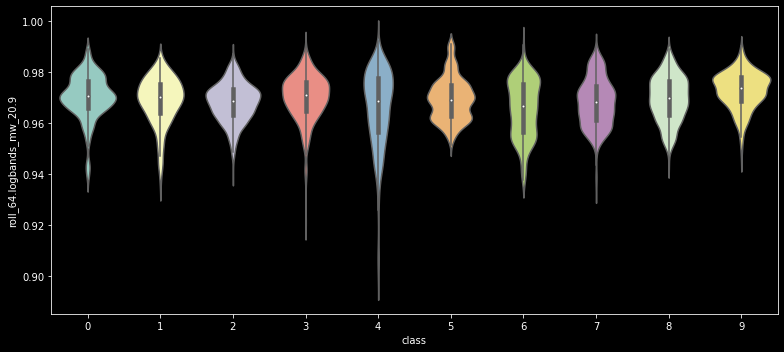

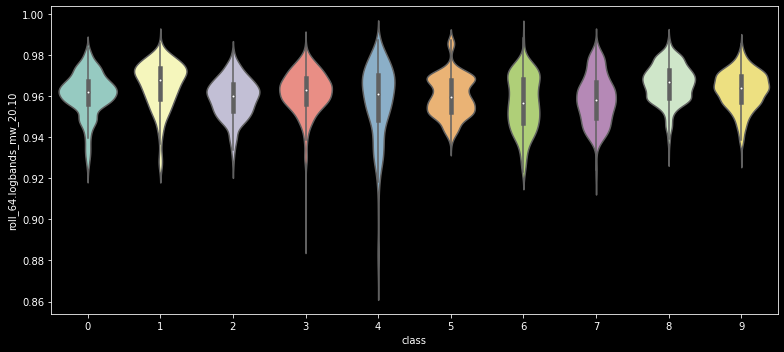

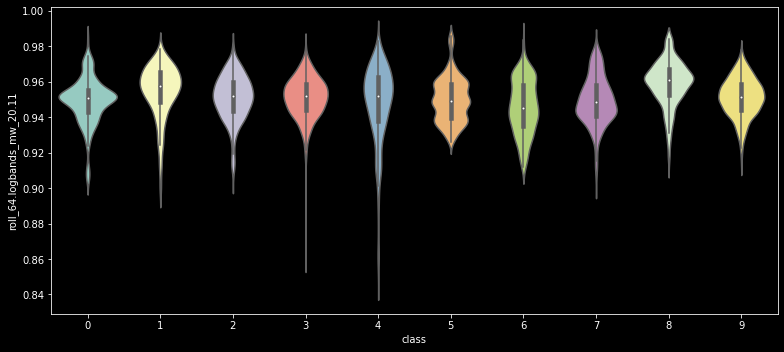

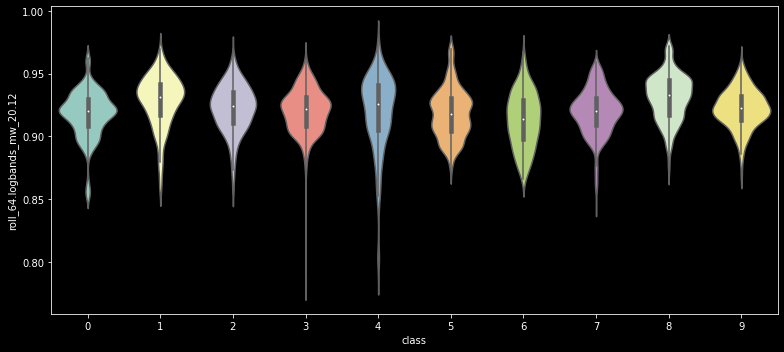

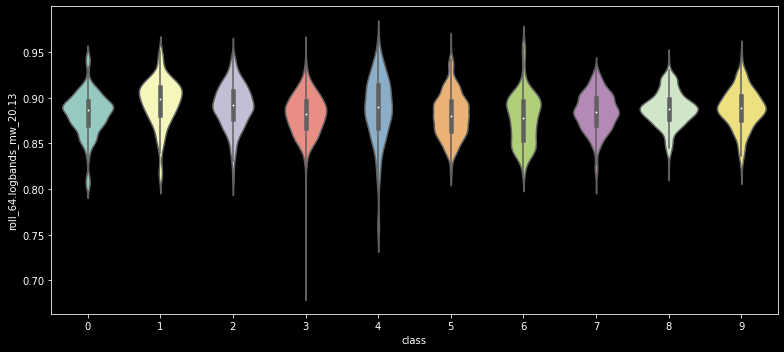

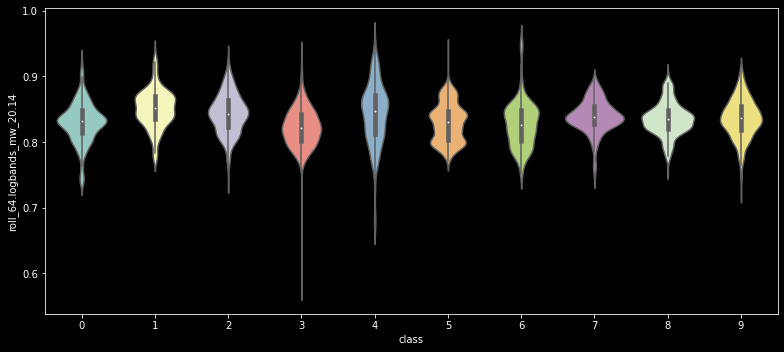

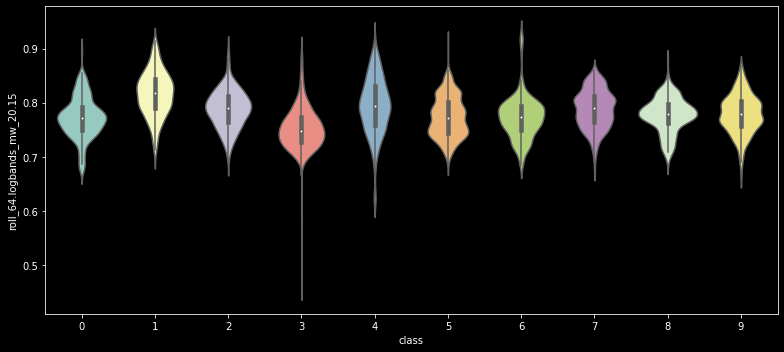

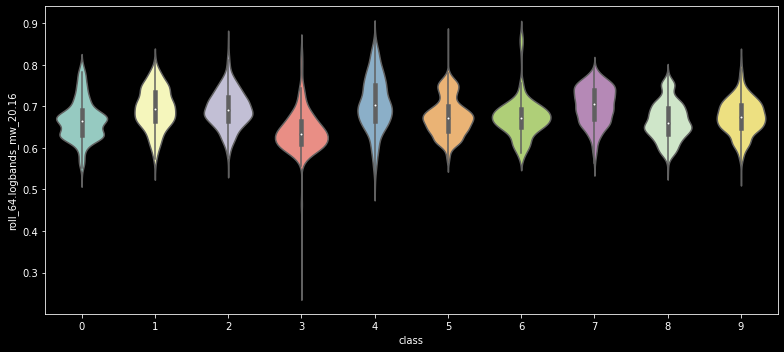

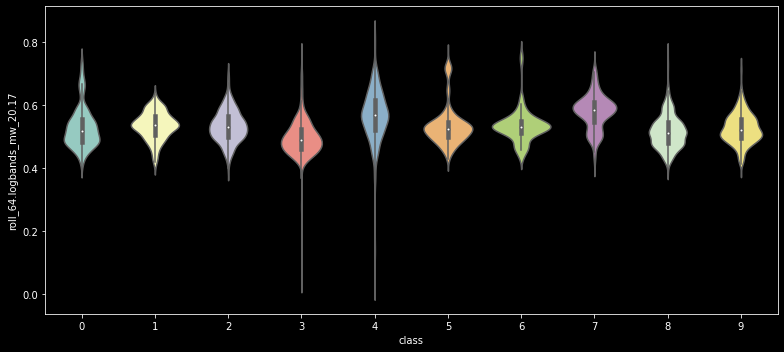

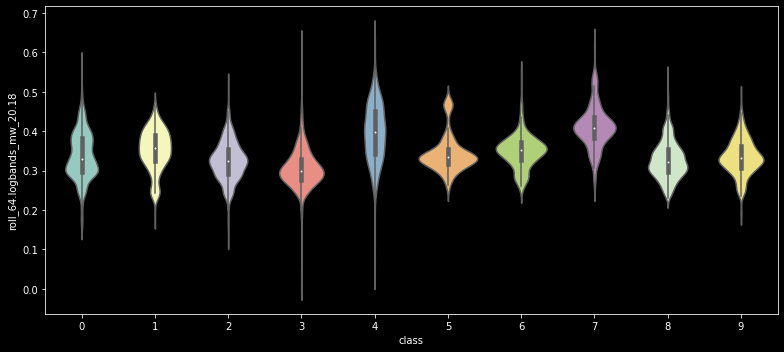

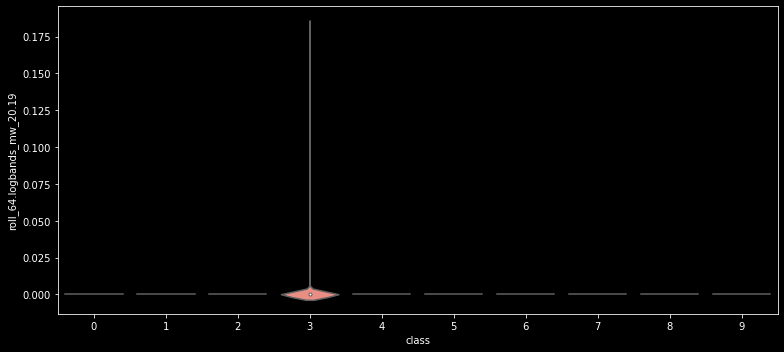

In [19]:
# Do some preliminary visualization to understand the feature distributions

for c in full_classify_keys:
    plt.figure(figsize=(11,5))
    sns.violinplot(data = cv_features_df,
                 x = 'class',
                 y = c)
    plt.tight_layout()
    plt.style.use('dark_background')
    plt.show()

## Setup: Define KPIs

In this section, we define functions to calculate KPIs.

In [20]:
# Define a helper function

def reduce_confmat(matrix):
    """
    Takes the N-dimensional confusion matrix as input and returns 
    a tuple (true positive, false positive, false negative) for the whole set.
    
    confusion matrix C is such that C_ij is equal to the 
    number of observations known to be in group i 
    and predicted to be in group j.
    """
    
    tps = [] # True positives for each axis
    fps = [] # True 
    fns = []
    
    for i in range(len(matrix)):
        tps.append(matrix[i,i]) # Append true positives for a class
        fps.append( np.delete(matrix[:,i],i).sum() ) # take sum, dropping the diagonal element
        fns.append( np.delete(matrix[i,:],i).sum() ) # take sum, dropping the diagonal element
        
    res = (tps, fps, fns)
    return res

In [21]:
# Define KPIs 

def TPR(data, prediction):
    """
    Returns True Positive Ratio given a prediction and data
    """
    confmat = confusion_matrix(data, prediction)
    
    (TP, FP, FN) = reduce_confmat(confmat)
    
    truepos = lambda a, b, c: a/(b+c)
    
    return [truepos(TP[i], TP[i], FN[i]) for i in range(len(TP))]
    

def recall(data, prediction):
    """
    Calculates recall of a prediction
    """
    
    confmat = confusion_matrix(data, prediction)

    (TP, FP, FN) = reduce_confmat(confmat)
    
    rec = lambda a, b, c: a/(b+c)
    
    return [rec(TP[i], TP[i], FN[i]) for i in range(len(TP))]
    

def precision(data, prediction):
    """
    Calculates precision of a prediction
    """
    
    confmat = confusion_matrix(data, prediction)

    (TP, FP, FN) = reduce_confmat(confmat)
    
    prec = lambda a, b, c: a/(b+c)
    
    return [prec(TP[i], TP[i], FP[i]) for i in range(len(TP))]
    

def Fmeasure(data, prediction):
    """
    Returns Fmeasure. 
    
    This is considered a balance of the precision and the recall.
    
    F = (2*P*R)/(P+R)
    
    where
    
    P = TP/(TP + FP) is the precision and
    R = TP/(TP + FN) is the recall.
    
    Reference: 
    Müller, Meinard. Fundamentals of music processing: Audio, analysis, algorithms, applications. 
    Vol. 5. Cham: Springer, 2015.
    Sec. 4.5 pp. 217
    """
    confmat = confusion_matrix(data, prediction)

    (TP, FP, FN) = reduce_confmat(confmat)
    
#     P = TP/(TP + FP)
#     R = TP/(TP + FN)
    
    workhorse = lambda a, b, c: a/(b+c)
    Fmeas = lambda x,y : (2*x*y)/(x+y)
    
    P = [workhorse(TP[i], TP[i], FP[i]) for i in range(len(TP))]
    R = [workhorse(TP[i], TP[i], FN[i]) for i in range(len(TP))]
    
    
    #F = (2*P*R)/(P + R)
    return [Fmeas(P[i],R[i]) for i in range(len(P))] #F
    

## Establishing a baseline: The Random Forest

### First: Feature selection with a Random Forest

In [22]:
# Get numerical arrays for inputs to models

if len(full_classify_keys) == 1:
    X_train = cv_features_df[full_classify_keys[0]].values.reshape(-1,1)
else:
    X_train = cv_features_df[full_classify_keys].values
    
y_train = cv_features_df['class'].values

X_test = validation_features_df[full_classify_keys].values
y_test = validation_features_df['class']

In [23]:
# Inspect the cross-validation features
cv_features_df.head()

class      eq_0     eq_10     eq_20     eq_30     eq_40     eq_60  \
0      3 -1.375995 -1.494469 -1.451719 -1.281426 -0.658946 -0.689535   
1      2  0.856480  0.821880  0.997462  0.783837  0.912475  0.721754   
2      2  0.819386  0.792283  0.720321  0.789714  0.724272  0.727021   
3      2  0.772997  0.642017  0.714451  0.829689  0.603400  0.852557   
4      2  0.931373  0.637854  0.799281  1.071200  0.785805  0.841281   

      eq_80    eq_120    eq_160  ...  range_high.f0_stats.f0_min  \
0 -0.606677 -0.516618 -0.041881  ...                  544.841599   
1  0.758189  0.456822  0.275369  ...                 2080.949703   
2  0.766071  0.408717  0.278678  ...                 1077.167118   
3  0.792330  0.878636  0.348520  ...                  523.251131   
4  0.746758  0.589374  0.427006  ...                 2057.047957   

   range_high.f0_signal  range_low.f0_stats.f0_mean  \
0              0.571429                         NaN   
1              0.109827                         NaN   
2              0.294798                 1128.712229   
3              0.260116                         NaN   
4              0.156069                   66.850514   

   range_low.f0_stats.f0_median  range_low.f0_stats.f0_std  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                   1115.153334                  36.960305   
3                           NaN                        NaN   
4                     65.785287                   1.875716   

   range_low.f0_stats.f0_iqr  range_low.f0_stats.f0_max  \
0                        NaN                        NaN   
1                        NaN                        NaN   
2                  57.225801                1195.191751   
3                        NaN                        NaN   
4                   1.731598                  70.915367   

   range_low.f0_stats.f0_min  power_ratio  hits_ratio  
0                        NaN     2.725290   -1.055247  
1                        NaN     0.553428   -3.301030  
2                1077.167118    -1.699984   -1.630523  
3                        NaN     0.889862   -1.567587  
4                  65.406391    -1.688568   -3.301030  

[5 rows x 406 columns]

In [24]:
# Once again, check for clean inputs.

set(np.where(np.isnan(X_train) == 1)[0])

set()

In [25]:
# Define the model
forest = make_pipeline(RobustScaler(), RandomForestClassifier(max_depth=15, n_estimators=1000,n_jobs=4))

In [26]:
# Fit the model
forest.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=15, n_estimators=1000,
                                        n_jobs=4))])

In [27]:
# Make predictions
pred = forest.predict(X_test)

### Establish baseline KPIs

In [28]:
# Look at KPIs for each class

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.29      0.18      0.22       100
           1       0.51      0.65      0.57        43
           2       0.48      0.69      0.57       100
           3       0.72      0.72      0.72       100
           4       0.35      0.58      0.43       100
           5       0.60      0.27      0.37       107
           6       0.82      1.00      0.90        36
           7       0.53      0.35      0.42       120
           8       0.79      0.61      0.69       119
           9       0.40      0.54      0.46       100

    accuracy                           0.52       925
   macro avg       0.55      0.56      0.54       925
weighted avg       0.54      0.52      0.51       925



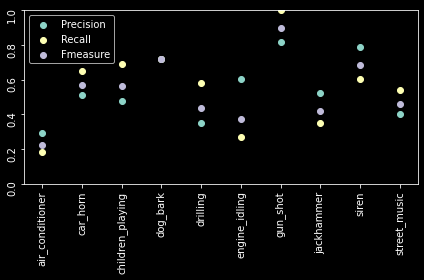

In [29]:
# Plot class KPIs in a more intuitive way for decision making

fig = plt.figure()
ax0 = fig.add_subplot(111)

ax0.scatter(classlabels,precision(y_test, pred),label='Precision')
ax0.scatter(classlabels,recall(y_test, pred),label='Recall')
ax0.scatter(classlabels,Fmeasure(y_test, pred),label='Fmeasure')

ax0.tick_params(rotation=90)
ax0.legend()
ax0.set_ylim(0,1)

plt.tight_layout()
plt.style.use('dark_background')
plt.show()

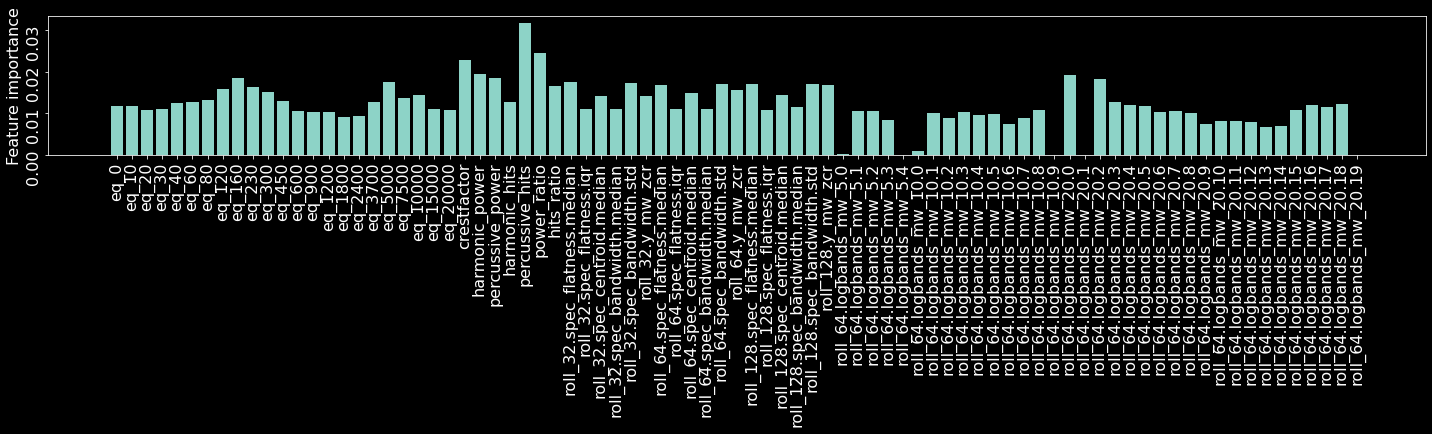

In [30]:
# Investigate feature importance in the Random Forest

fig = plt.figure(figsize=(20,6))
ax0 = fig.add_subplot(111)

ax0.bar(full_classify_keys,forest['randomforestclassifier'].feature_importances_)

ax0.tick_params(rotation=90,labelsize=16)
ax0.set_ylabel('Feature importance',fontsize=16)

plt.tight_layout()
plt.style.use('dark_background')
plt.savefig('feature_selection.png',dpi=600)
plt.show()

Now, we perform feature selection by only keeping the keys that contribute above a low threshold.

In [31]:
# Only keep keys above a low threshold
importance = forest['randomforestclassifier'].feature_importances_
keys_to_keep = (importance > 0.005) # create a filter for the keys
classify_keys = list(np.array(full_classify_keys)[keys_to_keep]) # filter keys based on feature importance

Now that we can see which features are important, we can reduce to only using this list and training another classifier.

In [32]:
# Re-define arrays only using the keys that matter

if len(classify_keys) == 1:
    X_train = cv_features_df[classify_keys[0]].values.reshape(-1,1)
else:
    X_train = cv_features_df[classify_keys].values
    
y_train = cv_features_df['class'].values

X_test = validation_features_df[classify_keys].values
y_test = validation_features_df['class']

In [33]:
# Re-define the model, re-fit, and re-train

forest = RandomForestClassifier(max_depth=15, n_estimators=1000,n_jobs=4)
forest.fit(X_train, y_train)
pred = forest.predict(X_test)

#### Re-establish baseline KPIs

In [34]:
# Look at class-specific KPIs again

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.34      0.20      0.25       100
           1       0.51      0.51      0.51        43
           2       0.48      0.69      0.56       100
           3       0.74      0.71      0.72       100
           4       0.35      0.59      0.44       100
           5       0.58      0.28      0.38       107
           6       0.77      1.00      0.87        36
           7       0.52      0.35      0.42       120
           8       0.83      0.61      0.70       119
           9       0.37      0.54      0.44       100

    accuracy                           0.51       925
   macro avg       0.55      0.55      0.53       925
weighted avg       0.54      0.51      0.51       925



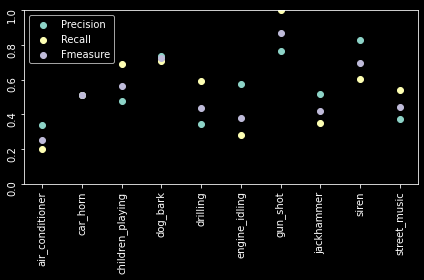

In [35]:
# Plot class KPIs in a more intuitive way for decision making

fig = plt.figure()
ax0 = fig.add_subplot(111)

ax0.scatter(classlabels,precision(y_test, pred),label='Precision')
ax0.scatter(classlabels,recall(y_test, pred),label='Recall')
ax0.scatter(classlabels,Fmeasure(y_test, pred),label='Fmeasure')

ax0.tick_params(rotation=90)
ax0.legend()
ax0.set_ylim(0,1)

plt.tight_layout()
plt.show()

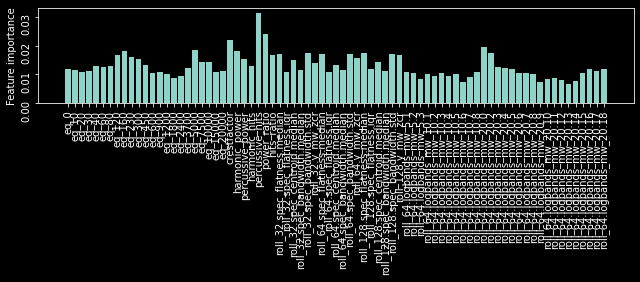

In [37]:
# Investigate feature importance in the Random Forest to ensure the keys are all important

fig = plt.figure(figsize=(9,4))
ax0 = fig.add_subplot(111)

ax0.bar(classify_keys,forest.feature_importances_)

ax0.tick_params(rotation=90)
ax0.set_ylabel('Feature importance')

plt.tight_layout()
plt.show()

In [38]:
# Full list of keys used for classification:
print(classify_keys)

['eq_0', 'eq_10', 'eq_20', 'eq_30', 'eq_40', 'eq_60', 'eq_80', 'eq_120', 'eq_160', 'eq_230', 'eq_300', 'eq_450', 'eq_600', 'eq_900', 'eq_1200', 'eq_1800', 'eq_2400', 'eq_3700', 'eq_5000', 'eq_7500', 'eq_10000', 'eq_15000', 'eq_20000', 'crestfactor', 'harmonic_power', 'percussive_power', 'harmonic_hits', 'percussive_hits', 'power_ratio', 'hits_ratio', 'roll_32.spec_flatness.median', 'roll_32.spec_flatness.iqr', 'roll_32.spec_centroid.median', 'roll_32.spec_bandwidth.median', 'roll_32.spec_bandwidth.std', 'roll_32.y_mw_zcr', 'roll_64.spec_flatness.median', 'roll_64.spec_flatness.iqr', 'roll_64.spec_centroid.median', 'roll_64.spec_bandwidth.median', 'roll_64.spec_bandwidth.std', 'roll_64.y_mw_zcr', 'roll_128.spec_flatness.median', 'roll_128.spec_flatness.iqr', 'roll_128.spec_centroid.median', 'roll_128.spec_bandwidth.median', 'roll_128.spec_bandwidth.std', 'roll_128.y_mw_zcr', 'roll_64.logbands_mw_5.1', 'roll_64.logbands_mw_5.2', 'roll_64.logbands_mw_5.3', 'roll_64.logbands_mw_10.1', 'rol

<Figure size 648x648 with 0 Axes>

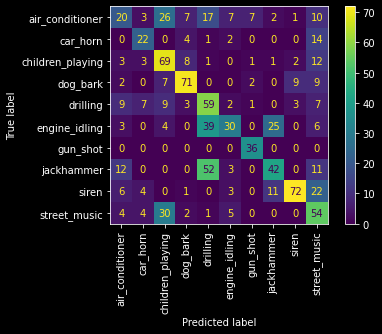

In [39]:
# Visualize the Confusion Matrix

plt.figure(figsize=(9,9))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,pred),display_labels=classlabels)
disp.plot(xticks_rotation='vertical')
plt.show()

The confusion matrix is interpretable; the air conditioner is a noisy quantity with a lot of environmental background, so naturally gets confused with other classes. The jackhammer is often confused for drilling while an idling engine is confused for a jackhammer. Since drills and jackhammers both have engines and are on noisy construction sites with vehicles, we see commonalities that make intuitive sense.

## Trying another model: A simple NN

We now investigate a multi-layer neural network classifier to investigate performance.

In [40]:
# Define and fit a sklearn neural network classifier

mlp = make_pipeline(MLPClassifier(hidden_layer_sizes=(150,150,150,150,150,), max_iter=100000, early_stopping=True))
mlp.fit(X_train, y_train)

Pipeline(steps=[('mlpclassifier',
                 MLPClassifier(early_stopping=True,
                               hidden_layer_sizes=(150, 150, 150, 150, 150),
                               max_iter=100000))])

In [41]:
# Make predictions with the sklearn NN classifier
pred_mlp = mlp.predict(X_test)

In [42]:
# Get report with KPIs for each class
print(classification_report(y_test,pred_mlp))

              precision    recall  f1-score   support

           0       0.38      0.45      0.41       100
           1       0.16      0.21      0.18        43
           2       0.77      0.24      0.37       100
           3       0.47      0.71      0.57       100
           4       0.30      0.62      0.41       100
           5       0.50      0.14      0.22       107
           6       0.62      0.86      0.72        36
           7       0.67      0.48      0.56       120
           8       0.57      0.39      0.46       119
           9       0.45      0.53      0.48       100

    accuracy                           0.45       925
   macro avg       0.49      0.46      0.44       925
weighted avg       0.51      0.45      0.44       925



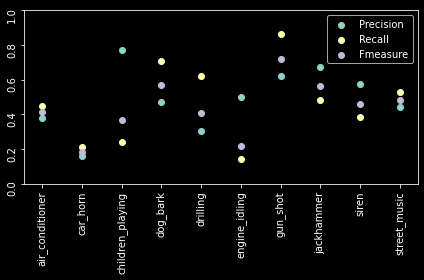

In [43]:
# Visualize KPIs per class more intuitively

fig = plt.figure()
ax0 = fig.add_subplot(111)

ax0.scatter(classlabels,precision(y_test, pred_mlp),label='Precision')
ax0.scatter(classlabels,recall(y_test, pred_mlp),label='Recall')
ax0.scatter(classlabels,Fmeasure(y_test, pred_mlp),label='Fmeasure')

ax0.tick_params(rotation=90)
ax0.legend()
ax0.set_ylim(0,1)

plt.tight_layout()
plt.show()

We once again see very good KPIs for the gunshot. This suggests that in the main category it is important to get right for our stakeholders, we do the best. This suggests that features such as crestfactor successfully encode relevant information.

<Figure size 648x648 with 0 Axes>

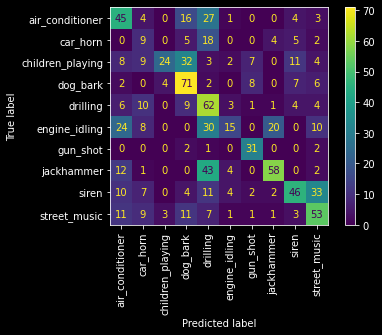

In [44]:
# Visualize the Confusion Matrix

plt.figure(figsize=(9,9))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,pred_mlp),display_labels=classlabels)
disp.plot(xticks_rotation='vertical')
plt.show()

The interpretation of the confusion matrix is similar to that of the Random Forest. gunshots now are confused more for drilling and dog barks, which can involve very sudden sounds. However, the NN classifier still has outstanding performance. The important thing is that *true* gunshots are successfully identified. A human can review recordings and screen for false positives, but false negatives are far more harmful.

## NN Classification using Keras

Is the NN classifier performance a specific feature of SciKit-Learn or is it a feature that can be replicated with more sophisticated NNs?

In [45]:
# Import packages for Keras

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 
from tensorflow.keras.metrics import CategoricalAccuracy, Recall, Precision 
# Additional metrics: https://www.tensorflow.org/api_docs/python/tf/keras/metrics

In [46]:
# Construct the model
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=len(classify_keys)))
model.add(Dense(350, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', 
              metrics=[Precision(),Recall(),CategoricalAccuracy()])

In [47]:
# Fit the model

n_epochs = 50
history = model.fit(X_train, to_categorical(y_train), epochs=n_epochs, verbose = 1,
              validation_data = (X_test, to_categorical(y_test)))

Epoch 1/50
244/244 [==============================] - 4s 6ms/step - loss: 22.6311 - precision: 0.1923 - recall: 0.1451 - categorical_accuracy: 0.1833 - val_loss: 2.1109 - val_precision: 0.4790 - val_recall: 0.0865 - val_categorical_accuracy: 0.2368
Epoch 2/50
244/244 [==============================] - 1s 4ms/step - loss: 2.1413 - precision: 0.4691 - recall: 0.0788 - categorical_accuracy: 0.2443 - val_loss: 2.1338 - val_precision: 0.7188 - val_recall: 0.0497 - val_categorical_accuracy: 0.2930
Epoch 3/50
244/244 [==============================] - 1s 4ms/step - loss: 1.9241 - precision: 0.5554 - recall: 0.0918 - categorical_accuracy: 0.2869 - val_loss: 2.0975 - val_precision: 0.5263 - val_recall: 0.0108 - val_categorical_accuracy: 0.2649
Epoch 4/50
244/244 [==============================] - 1s 4ms/step - loss: 1.8359 - precision: 0.5854 - recall: 0.0979 - categorical_accuracy: 0.3113 - val_loss: 1.9046 - val_precision: 0.2232 - val_recall: 0.0270 - val_categorical_accuracy: 0.2562
Epoch 5

Epoch 34/50
244/244 [==============================] - 1s 4ms/step - loss: 1.4262 - precision: 0.7480 - recall: 0.2882 - categorical_accuracy: 0.4896 - val_loss: 2.1903 - val_precision: 0.4966 - val_recall: 0.1557 - val_categorical_accuracy: 0.3449
Epoch 35/50
244/244 [==============================] - 1s 4ms/step - loss: 1.4399 - precision: 0.7312 - recall: 0.2882 - categorical_accuracy: 0.4933 - val_loss: 1.9991 - val_precision: 0.5586 - val_recall: 0.2011 - val_categorical_accuracy: 0.3762
Epoch 36/50
244/244 [==============================] - 1s 5ms/step - loss: 1.4355 - precision: 0.7418 - recall: 0.2863 - categorical_accuracy: 0.4940 - val_loss: 1.7922 - val_precision: 0.5692 - val_recall: 0.2000 - val_categorical_accuracy: 0.4011
Epoch 37/50
244/244 [==============================] - 1s 4ms/step - loss: 1.4200 - precision: 0.7350 - recall: 0.2909 - categorical_accuracy: 0.4917 - val_loss: 1.9487 - val_precision: 0.6173 - val_recall: 0.1308 - val_categorical_accuracy: 0.4281
Epoc

In [48]:
# Make predictions and evaluate

pred_train= model.predict(X_train)
scores = model.evaluate(X_train, to_categorical(y_train), verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, to_categorical(y_test), verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

244/244 [==============================] - 0s 2ms/step
Accuracy on training data: 0.8112019896507263% 
 Error on training data: 0.18879801034927368
29/29 [==============================] - 0s 2ms/step
Accuracy on test data: 0.6204379796981812% 
 Error on test data: 0.37956202030181885


In [49]:
# Format the Keras result so we can use the sklearn confusion_matrix function and visualizations
keras_confmat = confusion_matrix(to_categorical(y_test).argmax(axis=1), pred_test.argmax(axis=1))

<Figure size 648x648 with 0 Axes>

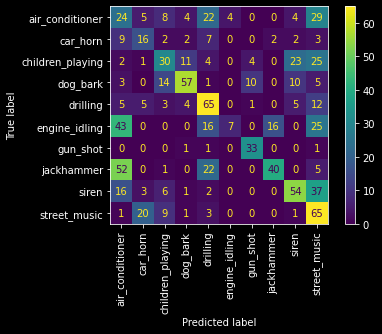

In [50]:
# Visualize the confusion matrix
plt.figure(figsize=(9,9))
disp = ConfusionMatrixDisplay(keras_confmat,display_labels=classlabels)
disp.plot(xticks_rotation='vertical')
plt.show()

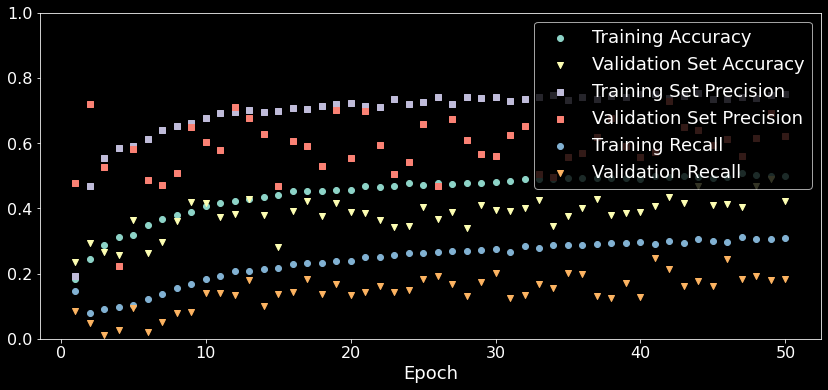

In [51]:
# Inspect how the model is improving over each training epoch

history_dict = history.history

plt.figure(figsize = (14,6))

plt.scatter(range(1,n_epochs+1), history_dict['categorical_accuracy'], label = "Training Accuracy")
plt.scatter(range(1,n_epochs+1), history_dict['val_categorical_accuracy'], marker='v', label = "Validation Set Accuracy")

plt.scatter(range(1,n_epochs+1), history_dict['precision'], marker='s', label = "Training Set Precision")
plt.scatter(range(1,n_epochs+1), history_dict['val_precision'], marker='s', label = "Validation Set Precision")

plt.scatter(range(1,n_epochs+1), history_dict['recall'], label = "Training Recall")
plt.scatter(range(1,n_epochs+1), history_dict['val_recall'], marker='v', label = "Validation Recall")

plt.xlabel("Epoch", fontsize=18)

plt.ylim(0,1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18,loc='upper right')

plt.show()

The metrics on the training and test set, as well as the confusion matrix, reveal that we get comparable performance with this Keras network, but that NNs may be struggling with noisy data as training accuracy and recall improve with no discernable impact on the validation set after the first few epochs. Additionally, this NN has perfect gunshot recall, but much poorer precision than the sklearn NN classifier. Precision also is fairly statitic over the training regime and is also low for gunshots. As precision is more important than recall to our stakeholders, this suggests that Keras NNs are not worth pursuing at this stage.

In [52]:
# Streamline the plotting process 

def make_class_scatter_plot(p,ytest,label):
    fig = plt.figure()
    ax0 = fig.add_subplot(111)

    ax0.scatter(classlabels,precision(ytest,p),label='Precision')
    ax0.scatter(classlabels,recall(ytest,p),label='Recall')
    ax0.scatter(classlabels,Fmeasure(ytest,p),label='Fmeasure')

    ax0.tick_params(rotation=90)
    ax0.legend()
    ax0.set_ylim(0,1)
    plt.title(f'Classifier: {label}')
    plt.tight_layout()
    plt.show()
    
def make_family_scatter_plot(p,ytest,label):
    fig = plt.figure()
    ax0 = fig.add_subplot(111)

    ax0.scatter(familylabels,precision(ytest,p),label='Precision')
    ax0.scatter(familylabels,recall(ytest,p),label='Recall')
    ax0.scatter(familylabels,Fmeasure(ytest,p),label='Fmeasure')

    ax0.tick_params(rotation=90)
    ax0.legend()
    ax0.set_ylim(0,1)
    plt.title(f'Classifier: {label}')
    plt.tight_layout()
    plt.show()

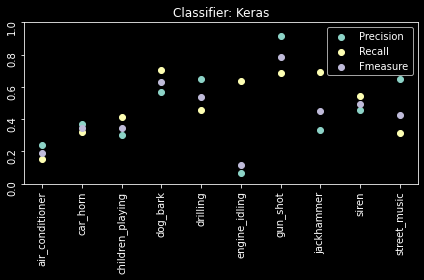

In [53]:
# Make scatter plot of KPIs for each class

make_class_scatter_plot(y_test,pred_test.argmax(axis=1),'Keras')

In [55]:
# Print numerical values of main KPIs

print(f'Gunshot recall: {100*recall(pred_test.argmax(axis=1),y_test)[6]} percent')
print(f'Gunshot precision: {100*precision(pred_test.argmax(axis=1),y_test)[6]} percent')

Gunshot recall: 68.75 percent
Gunshot precision: 91.66666666666666 percent


## Looping through specified models

Now that we have explored how classifiers behave and looked at feature importance, we loop through the collection of classifiers defined at the beginning of this notebook. These range from the simple to the more complex and will allow us to investigate if more complex classifiers are justified by their performance.

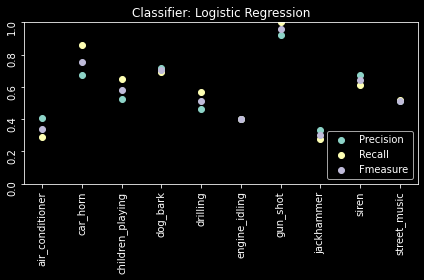

Logistic Regression Classifier accuracy score: 0.534054054054054
Logistic Regression Classifier gunshot recall score: 1.0
Logistic Regression Classifier gunshot precision score: 0.9230769230769231
Logistic Regression Classifier Precision: 0.5627824411539021
Logistic Regression Classifier Recall: 0.5870779653308833
Logistic Regression Classifier Fmeasure: 0.5709326019537692



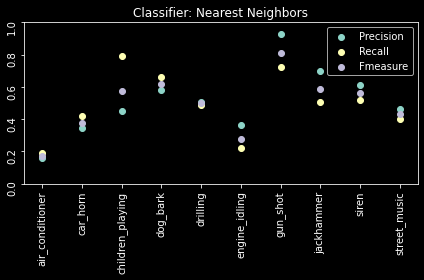

Nearest Neighbors Classifier accuracy score: 0.48
Nearest Neighbors Classifier gunshot recall score: 0.7222222222222222
Nearest Neighbors Classifier gunshot precision score: 0.9285714285714286
Nearest Neighbors Classifier Precision: 0.5112471321969865
Nearest Neighbors Classifier Recall: 0.4924467675500252
Nearest Neighbors Classifier Fmeasure: 0.4913079940576307



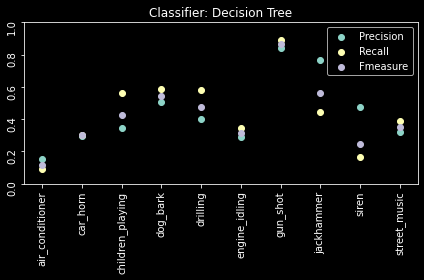

Decision Tree Classifier accuracy score: 0.4064864864864865
Decision Tree Classifier gunshot recall score: 0.8888888888888888
Decision Tree Classifier gunshot precision score: 0.8421052631578947
Decision Tree Classifier Precision: 0.4397598285401726
Decision Tree Classifier Recall: 0.43567427563650246
Decision Tree Classifier Fmeasure: 0.4199428617512876



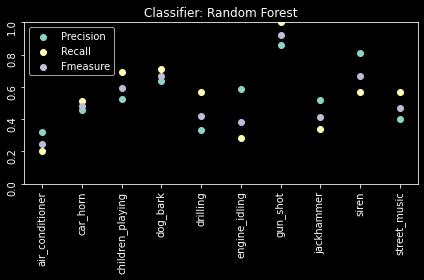

Random Forest Classifier accuracy score: 0.5091891891891892
Random Forest Classifier gunshot recall score: 1.0
Random Forest Classifier gunshot precision score: 0.8571428571428571
Random Forest Classifier Precision: 0.5438273529440691
Random Forest Classifier Recall: 0.5445096976847683
Random Forest Classifier Fmeasure: 0.5268188971539189



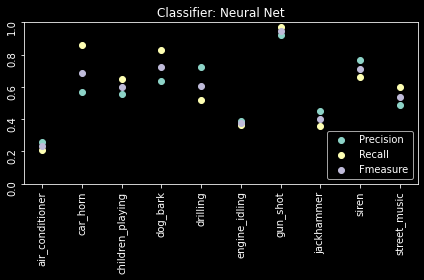

Neural Net Classifier accuracy score: 0.5556756756756757
Neural Net Classifier gunshot recall score: 0.9722222222222222
Neural Net Classifier gunshot precision score: 0.9210526315789473
Neural Net Classifier Precision: 0.5760047026282928
Neural Net Classifier Recall: 0.6029372199361525
Neural Net Classifier Fmeasure: 0.5814008893982529



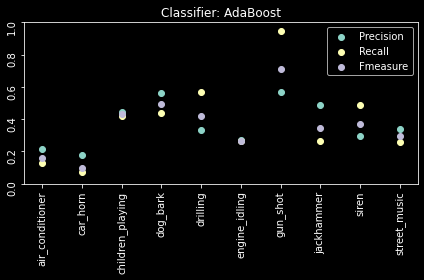

AdaBoost Classifier accuracy score: 0.3643243243243243
AdaBoost Classifier gunshot recall score: 0.9444444444444444
AdaBoost Classifier gunshot precision score: 0.5666666666666667
AdaBoost Classifier Precision: 0.3687069836953366
AdaBoost Classifier Recall: 0.3849955753945424
AdaBoost Classifier Fmeasure: 0.3587388758084637



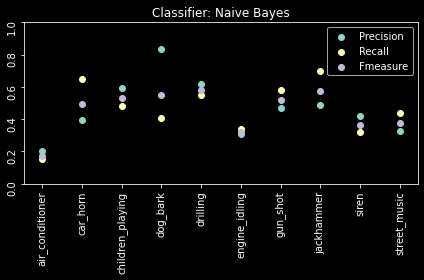

Naive Bayes Classifier accuracy score: 0.44324324324324327
Naive Bayes Classifier gunshot recall score: 0.5833333333333334
Naive Bayes Classifier gunshot precision score: 0.4666666666666667
Naive Bayes Classifier Precision: 0.46480055634068107
Naive Bayes Classifier Recall: 0.46202724532542866
Naive Bayes Classifier Fmeasure: 0.4476608587373847



/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
<ipython-input-21-77d999a9eda3>:70: RuntimeWarning: invalid value encountered in double_scalars
  Fmeas = lambda x,y : (2*x*y)/(x+y)


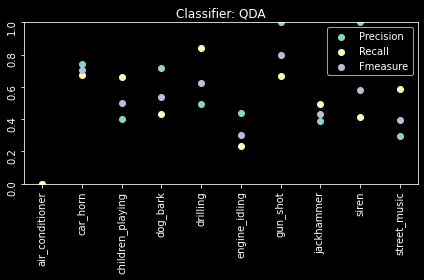

QDA Classifier accuracy score: 0.4735135135135135
QDA Classifier gunshot recall score: 0.6666666666666666
QDA Classifier gunshot precision score: 1.0
QDA Classifier Precision: 0.5475073875636285
QDA Classifier Recall: 0.4998161503679933
QDA Classifier Fmeasure: nan



<ipython-input-21-77d999a9eda3>:70: RuntimeWarning: invalid value encountered in double_scalars
  Fmeas = lambda x,y : (2*x*y)/(x+y)


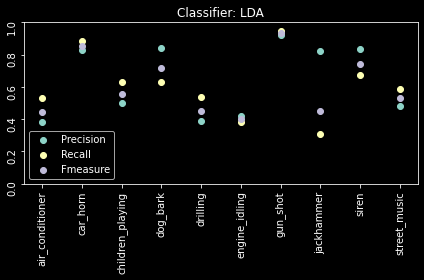

LDA Classifier accuracy score: 0.5643243243243243
LDA Classifier gunshot recall score: 0.9444444444444444
LDA Classifier gunshot precision score: 0.918918918918919
LDA Classifier Precision: 0.6405612824426019
LDA Classifier Recall: 0.6111945185666819
LDA Classifier Fmeasure: 0.6078295078889259



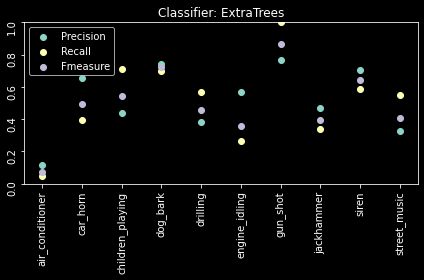

ExtraTrees Classifier accuracy score: 0.4864864864864865
ExtraTrees Classifier gunshot recall score: 1.0
ExtraTrees Classifier gunshot precision score: 0.7659574468085106
ExtraTrees Classifier Precision: 0.5177600703956358
ExtraTrees Classifier Recall: 0.516693304098427
ExtraTrees Classifier Fmeasure: 0.49584145521004624



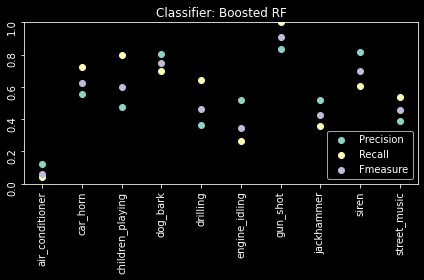

Boosted RF Classifier accuracy score: 0.5210810810810811
Boosted RF Classifier gunshot recall score: 1.0
Boosted RF Classifier gunshot precision score: 0.8372093023255814
Boosted RF Classifier Precision: 0.5406282245556325
Boosted RF Classifier Recall: 0.566598782568885
Boosted RF Classifier Fmeasure: 0.5328612328523071



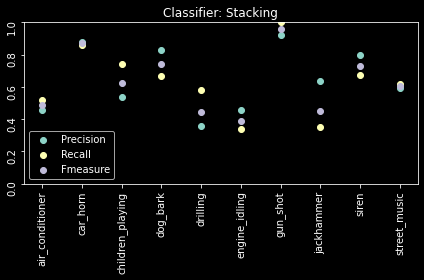

Stacking Classifier accuracy score: 0.5881081081081081
Stacking Classifier gunshot recall score: 1.0
Stacking Classifier gunshot precision score: 0.9230769230769231
Stacking Classifier Precision: 0.6466346509368069
Stacking Classifier Recall: 0.6349182621972937
Stacking Classifier Fmeasure: 0.6297375552864061



In [56]:
# Loop over models and make plots of KPIs for each class, printing numerical values

for i, classifier in enumerate(classifiers):

    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    make_class_scatter_plot(pred,y_test,names[i])
    print(f'{names[i]} Classifier accuracy score: {accuracy_score(y_test, pred)}')
    print(f'{names[i]} Classifier gunshot recall score: {recall(y_test, pred)[6]}')
    print(f'{names[i]} Classifier gunshot precision score: {precision(y_test, pred)[6]}')
    print(f'{names[i]} Classifier Precision: {np.mean(precision(y_test, pred))}')
    print(f'{names[i]} Classifier Recall: {np.mean(recall(y_test, pred))}')
    print(f'{names[i]} Classifier Fmeasure: {np.mean(Fmeasure(y_test, pred))}')
    print("")

For this training fold, the performances are summarized below. Bold denotes top 4 performance in two 2-way ties.

Note that these numbers vary slightly on each run of this notebook.

With only musically-informed features:

| Classifier   | Gunshot Recall | Cross-class Fmeasure |
|--------------|----------------|----------------------|
| Log. Reg.    | 0.889          | 0.504                |
| kNN          | 0.472          | 0.343                |
| Linear SVM   | 0.861          | 0.443                |
| Decision Tree| 0.833          | 0.402                |
| Random Forest| **0.972**      | **0.461**            |
| NN           | **0.944**      | **0.440**            |
| AdaBoost     | 0.861          | 0.330                |
| Naive Bayes  | 0.694          | nan                  |
| QDA          | 0.806          | 0.452                |
| LDA          | 0.889          | 0.519                |
| ExtraTrees   | 0.917          | 0.429                |
| Boosted RF   | **0.972**      | **0.447**            |

With a full features list chosen by the Random Forest:

| Classifier   | Gunshot Recall | Cross-class Fmeasure |
|--------------|----------------|----------------------|
| Log. Reg.    | **1.000**      | **0.571**            |
| kNN          | 0.722          | 0.491                |
| Decision Tree| 0.889          | 0.400                |
| Random Forest| **1.000**      | 0.536                |
| NN           | 0.750          | **0.554**            |
| AdaBoost     | 0.944          | 0.358                |
| Naive Bayes  | 0.583          | 0.446                |
| QDA          | 0.667          | nan                  |
| LDA          | 0.944          | **0.608**            |
| ExtraTrees   | **1.000**      | 0.490                |
| Boosted RF   | **1.000**      | **0.541**            |
| Stacking     | **1.000**      | **0.629**            |

The RandomForest (boosted or not) performs best on this cross-validation fold and the boosting appears to lower the Fmeasure. As a result, the RandomForest is the top candidate on this fold.

The Neutral Network is tied with GradientBoosting on this fold and GradientBoosting has a higher F-measure. This begins to suggest the top performing classifiers, but it's necessary to consider all folds before coming to a final conclusion.

Below, we interrogate the results of the final classifier, the stacking classifier, with more detailed metrics.

In [58]:
accuracy_score(pred,y_test)

0.5881081081081081

<Figure size 648x648 with 0 Axes>

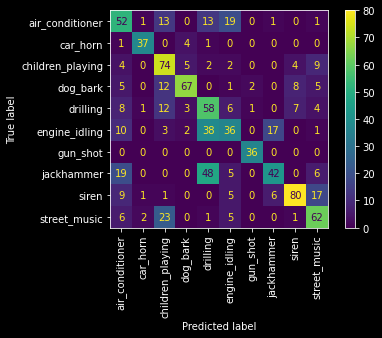

In [59]:
plt.figure(figsize=(9,9))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,pred),display_labels=classlabels)
disp.plot(xticks_rotation='vertical')
plt.style.use('dark_background')
plt.show()

## Trying out a Voting Classifier to beat the others

Voting classifiers are a form of ensemble learning where voters combine to create a more accurate prediction than any individual classifier. However, they can be very memory-intensive and are commented out to prevent accidental memory overruns.

In [57]:
# Create a voter list with all the classifiers in this notebook
# voter_list = [(names[i], classifiers[i]) for i in range(len(names))]

In [58]:
# Define the voting classifier
#voting = VotingClassifier(voter_list,
#                         voting='hard',
#                         n_jobs=4)

In [59]:
# Train the voting classifier
#voting.fit(X_train, y_train)

In [60]:
# Make a prediction
#vpred = voting.predict(X_test)


In [62]:
# Visualize class KPIs
#make_class_scatter_plot(vpred,y_test,'Voting')

In [64]:
# Visualize the confusion matrix

# plt.figure(figsize=(9,9))
# disp = ConfusionMatrixDisplay(confusion_matrix(y_test,vpred),display_labels=classlabels)
# disp.plot(xticks_rotation='vertical')
# plt.show()

While the gunshot recall has not improved, Fmeasure has, suggesting that the Voting Classifier achieves the most success. However, this is at significant cost in complexity and interpretability. It is up to a more involved comparison to determine if this is worthwhile.

### What about a stacking classifier?

In [60]:
# Define a stacked classifier combining different methods: 
# LDA, a Random Forest, and a Logistic Regression, all of which do well on their own

clf = StackingClassifier(estimators=[('LDA', make_pipeline(StandardScaler(),LinearDiscriminantAnalysis())),
    ('rf', RandomForestClassifier(max_depth=15,n_estimators=1000, random_state=42))
], final_estimator=LogisticRegression(max_iter=5000))

In [61]:
# Fit the stack
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('LDA',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('lineardiscriminantanalysis',
                                                 LinearDiscriminantAnalysis())])),
                               ('rf',
                                RandomForestClassifier(max_depth=15,
                                                       n_estimators=1000,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(max_iter=5000))

In [62]:
# Make a prediction
stackpred = clf.predict(X_test)

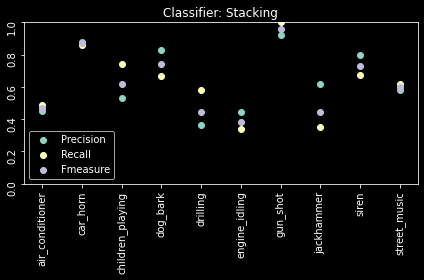

In [63]:
# Visualize class KPIs
make_class_scatter_plot(stackpred,y_test,'Stacking')

In [64]:
# Look at the classification report
print(classification_report(y_test,stackpred))

              precision    recall  f1-score   support

           0       0.45      0.49      0.47       100
           1       0.88      0.86      0.87        43
           2       0.53      0.74      0.62       100
           3       0.83      0.67      0.74       100
           4       0.36      0.58      0.45       100
           5       0.44      0.34      0.38       107
           6       0.92      1.00      0.96        36
           7       0.62      0.35      0.45       120
           8       0.80      0.67      0.73       119
           9       0.58      0.62      0.60       100

    accuracy                           0.58       925
   macro avg       0.64      0.63      0.63       925
weighted avg       0.61      0.58      0.58       925



This is also quite successful but without all the complexity of the voting classifier. This is potentially worth including in the list of classifiers.

## Considering all folds in validation

In [77]:
# Define arrays in which we will store KPIs

accuracies = np.zeros((10, len(names)))
Fs = np.zeros((10,len(names)))
recalls = np.zeros((10,len(names)))
precisions = np.zeros((10,len(names)))

gunshot_recalls = np.zeros((10,len(names)))
gunshot_precisions = np.zeros((10,len(names)))
gunshot_Fs = np.zeros((10,len(names)))

In [81]:
# Loop over cross-validation folds, storing KPIs

for dfi in range(0,10):
    dropfold = dfi + 1
    print(f'Fold {dropfold}')
    cv_features_df = features_df.drop(features_df[features_df['fold']==dropfold].index)
    validation_features_df = features_df.drop(features_df[features_df['fold']!=dropfold].index)

    if len(classify_keys) == 1:
        X_train = cv_features_df[classify_keys[0]].values.reshape(-1,1)
    else:
        X_train = cv_features_df[classify_keys].values

    y_train = cv_features_df['class'].values

    X_test = validation_features_df[classify_keys].values
    y_test = validation_features_df['class']

    for i, classifier in enumerate(classifiers):
        print(names[i])
        classifier.fit(X_train, y_train)
        pred = classifier.predict(X_test)
        
        accuracies[dfi][i] = accuracy_score(y_test, pred)
        Fs[dfi][i] = np.mean(Fmeasure(y_test, pred))
        recalls[dfi][i] = np.mean(recall(y_test, pred))
        precisions[dfi][i] = np.mean(precision(y_test, pred))
        
        gunshot_Fs[dfi][i] = Fmeasure(y_test, pred)[6]
        gunshot_recalls[dfi][i] = recall(y_test, pred)[6]
        gunshot_precisions[dfi][i] = precision(y_test, pred)[6]

Fold 1
Logistic Regression
Nearest Neighbors
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
LDA


/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
<ipython-input-21-8cd0e499882c>:27: RuntimeWarning: invalid value encountered in double_scalars
  Fmeas = lambda x,y : (2*x*y)/(x+y)
<ipython-input-21-8cd0e499882c>:27: RuntimeWarning: invalid value encountered in double_scalars
  Fmeas = lambda x,y : (2*x*y)/(x+y)


ExtraTrees
Boosted RF
Stacking
Fold 2
Logistic Regression
Nearest Neighbors
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
LDA


<ipython-input-21-8cd0e499882c>:27: RuntimeWarning: invalid value encountered in double_scalars
  Fmeas = lambda x,y : (2*x*y)/(x+y)
<ipython-input-21-8cd0e499882c>:27: RuntimeWarning: invalid value encountered in double_scalars
  Fmeas = lambda x,y : (2*x*y)/(x+y)
/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


ExtraTrees
Boosted RF
Stacking
Fold 3
Logistic Regression
Nearest Neighbors
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
LDA


/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
<ipython-input-21-8cd0e499882c>:27: RuntimeWarning: invalid value encountered in double_scalars
  Fmeas = lambda x,y : (2*x*y)/(x+y)
<ipython-input-21-8cd0e499882c>:27: RuntimeWarning: invalid value encountered in double_scalars
  Fmeas = lambda x,y : (2*x*y)/(x+y)


ExtraTrees
Boosted RF
Stacking
Fold 4
Logistic Regression
Nearest Neighbors
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
LDA


/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


ExtraTrees
Boosted RF
Stacking
Fold 5
Logistic Regression
Nearest Neighbors
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
LDA


/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


ExtraTrees
Boosted RF
Stacking
Fold 6
Logistic Regression
Nearest Neighbors
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
LDA


/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


ExtraTrees
Boosted RF
Stacking
Fold 7
Logistic Regression
Nearest Neighbors
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
LDA


/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


ExtraTrees
Boosted RF
Stacking
Fold 8
Logistic Regression
Nearest Neighbors
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
LDA


/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


ExtraTrees
Boosted RF
Stacking
Fold 9
Logistic Regression
Nearest Neighbors
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
LDA


/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


ExtraTrees
Boosted RF
Stacking
Fold 10
Logistic Regression
Nearest Neighbors
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
LDA


/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


ExtraTrees
Boosted RF
Stacking


In [82]:
# Produce summary statistics of KPIs to find the best model

accuracies_final = np.mean(accuracies,axis=0)
Fs_final = np.mean(Fs,axis=0)
recalls_final = np.mean(recalls,axis=0)
precisions_final = np.mean(precisions,axis=0)

Fs_finalerr = np.std(Fs,axis=0)/np.sqrt(Fs.shape[1])

gunshot_Fs_final = np.mean(gunshot_Fs,axis=0)
gunshot_recalls_final = np.mean(gunshot_recalls,axis=0)
gunshot_precisions_final = np.mean(gunshot_precisions,axis=0)

gunshot_Fs_finalerr = np.std(gunshot_Fs,axis=0)/np.sqrt(gunshot_precisions.shape[1])
gunshot_recalls_finalerr = np.std(gunshot_recalls,axis=0)/np.sqrt(gunshot_precisions.shape[1])
gunshot_precisions_finalerr = np.std(gunshot_precisions,axis=0)/np.sqrt(gunshot_precisions.shape[1])

In [83]:
# Look at KPIs

for i,name in enumerate(names):
    print(f'{name} overall accuracy: {np.round(accuracies_final[i],4)}')

Logistic Regression overall accuracy: 0.5895
Nearest Neighbors overall accuracy: 0.4992
Decision Tree overall accuracy: 0.4467
Random Forest overall accuracy: 0.597
Neural Net overall accuracy: 0.6017
AdaBoost overall accuracy: 0.3675
Naive Bayes overall accuracy: 0.448
QDA overall accuracy: 0.5151
LDA overall accuracy: 0.5842
ExtraTrees overall accuracy: 0.5772
Boosted RF overall accuracy: 0.6102
Stacking overall accuracy: 0.6327


In [84]:
# Look at KPIs

for i,name in enumerate(names):
    print(f'{name} overall Fmeasure: {np.round(Fs_final[i],4)}')

Logistic Regression overall Fmeasure: 0.607
Nearest Neighbors overall Fmeasure: 0.4881
Decision Tree overall Fmeasure: 0.4402
Random Forest overall Fmeasure: 0.5938
Neural Net overall Fmeasure: 0.6019
AdaBoost overall Fmeasure: 0.3599
Naive Bayes overall Fmeasure: nan
QDA overall Fmeasure: nan
LDA overall Fmeasure: 0.5978
ExtraTrees overall Fmeasure: 0.57
Boosted RF overall Fmeasure: 0.6107
Stacking overall Fmeasure: 0.6469


In [85]:
# Look at KPIs

for i,name in enumerate(names):
    print(f'{name} overall recall: {np.round(recalls_final[i],4)}')

Logistic Regression overall recall: 0.6129
Nearest Neighbors overall recall: 0.4925
Decision Tree overall recall: 0.4474
Random Forest overall recall: 0.6
Neural Net overall recall: 0.6161
AdaBoost overall recall: 0.3783
Naive Bayes overall recall: 0.4512
QDA overall recall: 0.5127
LDA overall recall: 0.6014
ExtraTrees overall recall: 0.5744
Boosted RF overall recall: 0.6178
Stacking overall recall: 0.6502


In [86]:
# Look at KPIs

for i,name in enumerate(names):
    print(f'{name} overall precision: {np.round(precisions_final[i],4)}')

Logistic Regression overall precision: 0.6219
Nearest Neighbors overall precision: 0.5087
Decision Tree overall precision: 0.4536
Random Forest overall precision: 0.62
Neural Net overall precision: 0.6136
AdaBoost overall precision: 0.3743
Naive Bayes overall precision: 0.4736
QDA overall precision: 0.6265
LDA overall precision: 0.6274
ExtraTrees overall precision: 0.61
Boosted RF overall precision: 0.6374
Stacking overall precision: 0.667


In [87]:
# Look at KPIs

for i,name in enumerate(names):
    print(f'{name} gunshot precision: {np.round(gunshot_precisions_final[i],4)} +/- {np.round(gunshot_precisions_finalerr[i],4)} ')

Logistic Regression gunshot precision: 0.867 +/- 0.0147 
Nearest Neighbors gunshot precision: 0.6654 +/- 0.0445 
Decision Tree gunshot precision: 0.7274 +/- 0.0405 
Random Forest gunshot precision: 0.8779 +/- 0.0296 
Neural Net gunshot precision: 0.8193 +/- 0.031 
AdaBoost gunshot precision: 0.4488 +/- 0.0325 
Naive Bayes gunshot precision: 0.5481 +/- 0.0516 
QDA gunshot precision: 0.9972 +/- 0.0024 
LDA gunshot precision: 0.7285 +/- 0.0404 
ExtraTrees gunshot precision: 0.886 +/- 0.0295 
Boosted RF gunshot precision: 0.8864 +/- 0.0286 
Stacking gunshot precision: 0.8435 +/- 0.0414 


In [88]:
# Look at KPIs

for i,name in enumerate(names):
    print(f'{name} gunshot recall: {np.round(gunshot_recalls_final[i],4)} +/- {np.round(gunshot_recalls_finalerr[i],4)} ')

Logistic Regression gunshot recall: 0.8819 +/- 0.0334 
Nearest Neighbors gunshot recall: 0.5065 +/- 0.0483 
Decision Tree gunshot recall: 0.6269 +/- 0.0618 
Random Forest gunshot recall: 0.8038 +/- 0.0544 
Neural Net gunshot recall: 0.7951 +/- 0.0445 
AdaBoost gunshot recall: 0.7131 +/- 0.0441 
Naive Bayes gunshot recall: 0.5657 +/- 0.0363 
QDA gunshot recall: 0.5674 +/- 0.0529 
LDA gunshot recall: 0.7964 +/- 0.0384 
ExtraTrees gunshot recall: 0.774 +/- 0.0507 
Boosted RF gunshot recall: 0.8182 +/- 0.0539 
Stacking gunshot recall: 0.8666 +/- 0.0371 


In [89]:
# Look at KPIs

for i,name in enumerate(names):
    print(f'{name} gunshot Fmeasure: {np.round(gunshot_Fs_final[i],4)} +/- {np.round(gunshot_Fs_finalerr[i],4)} ')

Logistic Regression gunshot Fmeasure: 0.8706 +/- 0.0204 
Nearest Neighbors gunshot Fmeasure: 0.5662 +/- 0.0455 
Decision Tree gunshot Fmeasure: 0.6636 +/- 0.0498 
Random Forest gunshot Fmeasure: 0.8285 +/- 0.039 
Neural Net gunshot Fmeasure: 0.7955 +/- 0.0313 
AdaBoost gunshot Fmeasure: 0.5456 +/- 0.0354 
Naive Bayes gunshot Fmeasure: 0.5515 +/- 0.0418 
QDA gunshot Fmeasure: 0.7042 +/- 0.0458 
LDA gunshot Fmeasure: 0.7563 +/- 0.0376 
ExtraTrees gunshot Fmeasure: 0.8154 +/- 0.037 
Boosted RF gunshot Fmeasure: 0.8392 +/- 0.0377 
Stacking gunshot Fmeasure: 0.8451 +/- 0.0344 


In [90]:
# Print KPIs so they make a pretty markdown table

print("| Classifier   | Gunshot Recall | Gunshot Fmeasure | Cross-class Fmeasure | \n|--------------|----------------|----------------------|----------------------|")
for i,name in enumerate(names):
    print(f'| {name} | {np.round(gunshot_recalls_final[i],4)} +/- {np.round(gunshot_recalls_finalerr[i],4)}  | {np.round(gunshot_Fs_final[i],4)} +/- {np.round(gunshot_Fs_finalerr[i],4)}  | {np.round(Fs_final[i],4)} +/- {np.round(Fs_finalerr[i],3)} |')

| Classifier   | Gunshot Recall | Gunshot Fmeasure | Cross-class Fmeasure | 
|--------------|----------------|----------------------|----------------------|
| Logistic Regression | 0.8819 +/- 0.0334  | 0.8706 +/- 0.0204  | 0.607 +/- 0.007 |
| Nearest Neighbors | 0.5065 +/- 0.0483  | 0.5662 +/- 0.0455  | 0.4881 +/- 0.015 |
| Decision Tree | 0.6269 +/- 0.0618  | 0.6636 +/- 0.0498  | 0.4402 +/- 0.014 |
| Random Forest | 0.8038 +/- 0.0544  | 0.8285 +/- 0.039  | 0.5938 +/- 0.011 |
| Neural Net | 0.7951 +/- 0.0445  | 0.7955 +/- 0.0313  | 0.6019 +/- 0.014 |
| AdaBoost | 0.7131 +/- 0.0441  | 0.5456 +/- 0.0354  | 0.3599 +/- 0.011 |
| Naive Bayes | 0.5657 +/- 0.0363  | 0.5515 +/- 0.0418  | nan +/- nan |
| QDA | 0.5674 +/- 0.0529  | 0.7042 +/- 0.0458  | nan +/- nan |
| LDA | 0.7964 +/- 0.0384  | 0.7563 +/- 0.0376  | 0.5978 +/- 0.012 |
| ExtraTrees | 0.774 +/- 0.0507  | 0.8154 +/- 0.037  | 0.57 +/- 0.014 |
| Boosted RF | 0.8182 +/- 0.0539  | 0.8392 +/- 0.0377  | 0.6107 +/- 0.014 |
| Stacking | 0.8

Below are the final results for selected KPIs. We see that the main KPI, Gunshot Recall, is highest for the neural net, but other KPIs such as Gunshot Fmeasure (which penalizes false positives) and overall Fmeasure are lower for the neural net. Nonetheless, the primary thing to be classified for our stakeholders is gunshots and other sounds are additional benefits that can potentially be classified at a later stage and are not safety-critical.

With only musical features:

| Classifier          | Gunshot Recall | Gunshot Fmeasure | Cross-class Fmeasure | 
|---------------------|----------|------------|------------|
| Logistic Regression | 0.7875 | 0.7756 | 0.5427 |
| Nearest Neighbors   | 0.5646 | 0.6342 | 0.3689 |
| Linear SVM          | 0.8227 | 0.7884 | 0.5194 |
| RBF SVM             | 0.0041 | nan    |    nan |
| Decision Tree       | 0.7311 | 0.7006 | 0.4135 |
| Random Forest       | **0.8367** | **0.8173** | **0.5483** |
| Neural Net          | **0.8473** | **0.7945** | 0.5255 |
| AdaBoost            | 0.7639 | 0.5883 | 0.3741 |
| Naive Bayes         | 0.6359 | 0.5342 |    nan |
| QDA                 | 0.6783 | 0.753  | **0.5443** |
| LDA                 | 0.7823 | 0.7324 | 0.5392 |
| ExtraTrees          | 0.7592 | 0.7789 | 0.5033 |
| Boosted RF          | **0.8244** | **0.8323** | **0.5422** |
| GradientBoosting    | 0.8065 | 0.7857 | 0.5396 |

And, with error bars:

| Classifier   | Gunshot Recall | Gunshot Fmeasure | Cross-class Fmeasure | 
|--------------|----------------|----------------------|----------------------|
| Logistic Regression | 0.7875 +/- 0.0303  | 0.7756 +/- 0.0187  | 0.5427 +/- 0.009 |
| Nearest Neighbors | 0.5646 +/- 0.0458  | 0.6342 +/- 0.0367  | 0.3689 +/- 0.01 |
| Linear SVM | 0.8227 +/- 0.0343  | 0.7884 +/- 0.0184  | 0.5194 +/- 0.011 |
| RBF SVM | 0.0041 +/- 0.0022  | nan +/- nan  | nan +/- nan |
| Decision Tree | 0.7311 +/- 0.0412  | 0.7006 +/- 0.0332  | 0.4135 +/- 0.01 |
| Random Forest | **0.8367 +/- 0.0425**  | **0.8173 +/- 0.0338**  | **0.5483 +/- 0.012** |
| Neural Net | **0.8473 +/- 0.0326**  | **0.7945 +/- 0.0256**  | 0.5255 +/- 0.015 |
| AdaBoost | 0.7639 +/- 0.0278  | 0.5883 +/- 0.0185  | 0.3741 +/- 0.011 |
| Naive Bayes | 0.6359 +/- 0.0616  | 0.5342 +/- 0.0461  | nan +/- nan |
| QDA | 0.6783 +/- 0.0405  | 0.753 +/- 0.0238  | **0.5443 +/- 0.012** |
| LDA | 0.7823 +/- 0.0377  | 0.7324 +/- 0.0249  | 0.5392 +/- 0.011 |
| ExtraTrees | 0.7592 +/- 0.0595  | 0.7789 +/- 0.0471  | 0.5033 +/- 0.015 |
| Boosted RF | **0.8244 +/- 0.0447**  | **0.8323 +/- 0.0316**  | **0.5422 +/- 0.014** |
| GradientBoosting | 0.8065 +/- 0.0511  | 0.7857 +/- 0.0372  | 0.5396 +/- 0.013 |

Finally, with all features selected by a Random Forest:

| Classifier   | Gunshot Recall | Gunshot Fmeasure | Cross-class Fmeasure | 
|--------------|----------------|----------------------|----------------------|
| Logistic Regression | **0.8819 +/- 0.0334**  | **0.8706 +/- 0.0204**  | **0.607 +/- 0.007** |
| Nearest Neighbors   | 0.5065 +/- 0.0483  | 0.5662 +/- 0.0455  | 0.4881 +/- 0.015 |
| Decision Tree       | 0.6269 +/- 0.0618  | 0.6636 +/- 0.0498  | 0.4402 +/- 0.014 |
| Random Forest       | 0.8038 +/- 0.0544  | 0.8285 +/- 0.039  | 0.5938 +/- 0.011 |
| Neural Net          | 0.7951 +/- 0.0445  | 0.7955 +/- 0.0313  | 0.6019 +/- 0.014 |
| AdaBoost            | 0.7131 +/- 0.0441  | 0.5456 +/- 0.0354  | 0.3599 +/- 0.011 |
| Naive Bayes         | 0.5657 +/- 0.0363  | 0.5515 +/- 0.0418  | nan +/- nan |
| QDA                 | 0.5674 +/- 0.0529  | 0.7042 +/- 0.0458  | nan +/- nan |
| LDA                 | 0.7964 +/- 0.0384  | 0.7563 +/- 0.0376  | 0.5978 +/- 0.012 |
| ExtraTrees          | 0.774 +/- 0.0507   | 0.8154 +/- 0.037  | 0.57 +/- 0.014 |
| Boosted RF          | **0.8182 +/- 0.0539**  | **0.8392 +/- 0.0377**  | **0.6107 +/- 0.014** |
| Stacking            | **0.8666 +/- 0.0371**  | **0.8451 +/- 0.0344**  | **0.6469 +/- 0.011** |

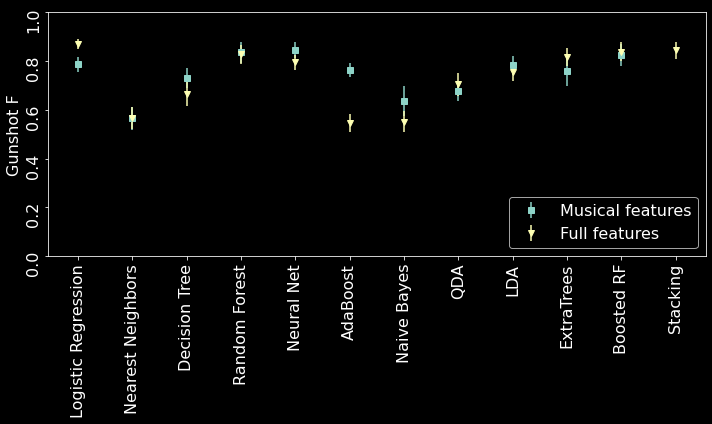

In [256]:
fig = plt.figure(figsize=(10,6))
ax0 = fig.add_subplot(111)

ax0.errorbar(names,[0.7875, 0.5646, 0.7311, 0.8367, 0.8473, 0.7639, 0.6359, 0.6783, 0.7823, 0.7592, 0.8244, -1],yerr=[0.0303, 0.0458, 0.0412, 0.0425, 0.0326, 0.0278, 0.0616, 0.0405, 0.0377, 0.0595, 0.0447, 0], marker='s',linestyle='none',label='Musical features')
ax0.errorbar(names,gunshot_Fs_final,yerr=gunshot_Fs_finalerr, marker='v',linestyle='none',label='Full features')
ax0.tick_params(rotation=90,labelsize=16)

plt.ylabel('Gunshot F',fontsize=16)
plt.legend(loc='lower right',fontsize=16)
plt.ylim(0,1)
plt.tight_layout()
plt.style.use('dark_background')
plt.savefig('fullvsmusicalFs.png',dpi=300)
plt.show()

<Figure size 648x648 with 0 Axes>

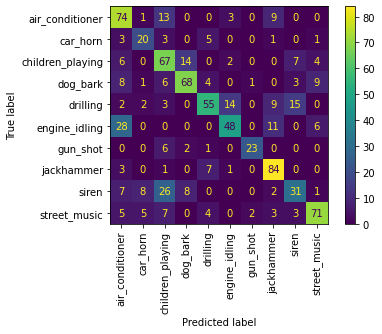

In [110]:
logistic = classifiers[0]
prediction = logistic.predict(X_test)
plt.figure(figsize=(9,9))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,prediction),display_labels=classlabels)
disp.plot(xticks_rotation='vertical')
plt.show()

## Now: Tune the best models

Now that a preliminary search of the classifier space has given us a ranking of classifiers, we can focus the search on a more limited number of methods. We can then tune these hyperparameters for optimal performance.

Preliminary model ranking:
   1. Random Forest (Boosted is comparable)
   2. Neural Net (see if it can be improved to differentiate from the logistic regression)

### First: Tuning the Random Forest

In [91]:
# Create an array of estimators

n_estimators = np.arange(10,1100,100)

In [92]:
# Loop over the number of estimators and save KPIs

acc = []
gsr = []
for n in n_estimators:
    print(n)
    forest = RandomForestClassifier(max_depth=15, n_estimators=n,n_jobs=4)
    forest.fit(X_train,y_train)
    fpred = forest.predict(X_test)
    acc.append(accuracy_score(y_test,fpred))
    gsr.append(recall(y_test,fpred)[6])

10
110
210
310
410
510
610
710
810
910
1010


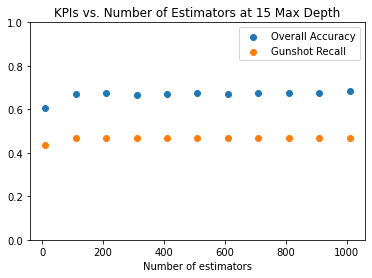

In [93]:
# Visualize KPIs vs estimators 

plt.figure()
plt.scatter(n_estimators,acc,label='Overall Accuracy')
plt.scatter(n_estimators,gsr,label='Gunshot Recall')
plt.xlabel('Number of estimators')
plt.title('KPIs vs. Number of Estimators at 15 Max Depth')
plt.legend()
plt.ylim(0,1)
plt.show()

In [94]:
# Investigate Random Forest dependence on maximum depth

maxdepths = np.arange(1,30,2)
mdacc = []
mdgsr = []
for m in maxdepths:
    print(m)
    forest = make_pipeline(RobustScaler(),RandomForestClassifier(max_depth=m, n_estimators=200,n_jobs=6))
    forest.fit(X_train,y_train)
    fpred = forest.predict(X_test)
    mdacc.append(accuracy_score(y_test,fpred))
    mdgsr.append(recall(y_test,fpred)[6])

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29


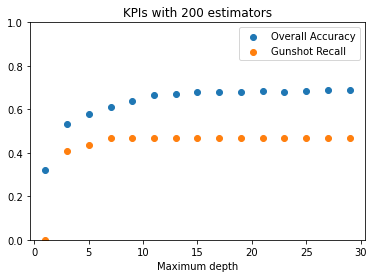

In [95]:
# Visualize KPIs vs depth

plt.figure()
plt.scatter(maxdepths,mdacc,label='Overall Accuracy')
plt.scatter(maxdepths,mdgsr,label='Gunshot Recall')
plt.xlabel('Maximum depth')
plt.title('KPIs with 200 estimators')
plt.legend()
plt.ylim(0,1)
plt.show()

### Tuning the Neural Network

In [96]:
# Define list of layers
nlayers = [n for n in range(1,11)]

In [97]:
# Fit model and calculate KPIs for number of layers with 150 neurons

nn_acc = []
nn_gsr = []

for l in nlayers:
    print(l)
    mlp = MLPClassifier(hidden_layer_sizes=(150,)*l, max_iter=100000, early_stopping=True)
    mlp.fit(X_train, y_train)
    mlp_pred = mlp.predict(X_test)
    nn_acc.append(accuracy_score(y_test,mlp_pred))
    nn_gsr.append(recall(y_test,mlp_pred)[6])

1
2
3
4
5
6
7
8
9
10


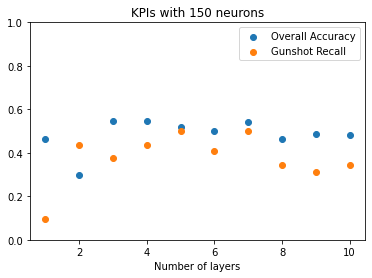

In [98]:
# Visualize KPIs vs layers

plt.figure()
plt.scatter(nlayers,nn_acc,label='Overall Accuracy')
plt.scatter(nlayers,nn_gsr,label='Gunshot Recall')
plt.xlabel('Number of layers')
plt.title('KPIs with 150 neurons')
plt.legend()
plt.ylim(0,1)
plt.show()

In [99]:
# Investigate layer sizes from 30 to 210 in intervals of 40

layersizes = [(n,) for n in np.arange(30,210,40)]

In [100]:
# Fit model and save KPIs

nnl_acc = []
nnl_gsr = []

for s in layersizes:
    print(s)
    mlp = MLPClassifier(hidden_layer_sizes=s*5, max_iter=100000, early_stopping=True)
    mlp.fit(X_train, y_train)
    mlp_pred = mlp.predict(X_test)
    nnl_acc.append(accuracy_score(y_test,mlp_pred))
    nnl_gsr.append(recall(y_test,mlp_pred)[6])

(30,)
(70,)
(110,)
(150,)
(190,)


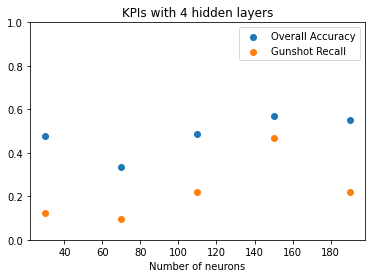

In [101]:
# Visualize KPIs vs number of neurons in a 5 layers

plt.figure()
plt.scatter([n[0] for n in layersizes],nnl_acc,label='Overall Accuracy')
plt.scatter([n[0] for n in layersizes],nnl_gsr,label='Gunshot Recall')
plt.xlabel('Number of neurons')
plt.title('KPIs with 5 hidden layers')
plt.legend()
plt.ylim(0,1)
plt.show()

So it seems that the parameters we had to begin with were quite successful for the Neural Network!

## Calculate additional KPIs for best models



In [219]:
# Define arrays, lists to iterate through

best_Fs = np.zeros((10,2,len(classlabels)))
best_recalls = np.zeros((10,2,len(classlabels)))
best_precisions = np.zeros((10,2,len(classlabels)))

best_classifiers = [make_pipeline(RobustScaler(), LogisticRegression(max_iter=10000, n_jobs=4)),
                    make_pipeline(RobustScaler(), AdaBoostClassifier(RandomForestClassifier(max_depth=15, n_estimators=200,n_jobs=4)))]
best_classifier_names = ['Logistic Regression', 'Boosted Random Forest']

In [220]:
# Loop over classifiers and folds
for dfi in range(0,10):
    dropfold = dfi + 1
    print(f'Fold {dropfold}')
    cv_features_df = features_df.drop(features_df[features_df['fold']==dropfold].index)
    validation_features_df = features_df.drop(features_df[features_df['fold']!=dropfold].index)

    if len(classify_keys) == 1:
        X_train = cv_features_df[classify_keys[0]].values.reshape(-1,1)
    else:
        X_train = cv_features_df[classify_keys].values

    y_train = cv_features_df['class'].values

    X_test = validation_features_df[classify_keys].values
    y_test = validation_features_df['class']

    for i, classifier in enumerate(best_classifiers):
        print(best_classifier_names[i])
        classifier.fit(X_train, y_train)
        pred = classifier.predict(X_test)
        
        best_Fs[dfi][i] = Fmeasure(y_test, pred)
        best_recalls[dfi][i] = recall(y_test, pred)
        best_precisions[dfi][i] = precision(y_test, pred)
        

Fold 1
Logistic Regression
Boosted Random Forest
Fold 2
Logistic Regression
Boosted Random Forest
Fold 3
Logistic Regression
Boosted Random Forest
Fold 4
Logistic Regression
Boosted Random Forest
Fold 5
Logistic Regression
Boosted Random Forest
Fold 6
Logistic Regression
Boosted Random Forest
Fold 7
Logistic Regression
Boosted Random Forest
Fold 8
Logistic Regression
Boosted Random Forest
Fold 9
Logistic Regression
Boosted Random Forest
Fold 10
Logistic Regression
Boosted Random Forest


In [237]:
# Calculate summary statistics over folds

F_means = np.mean(best_Fs,axis=0) # Have to figure out the axes that give us 10x2
F_errs = np.std(best_Fs,axis=0)/np.sqrt(10)
print(F_means)

[[0.37144724 0.66827325 0.59812157 0.71908371 0.57372788 0.4510559
  0.87057342 0.55051588 0.6449223  0.62191765]
 [0.40939502 0.51478128 0.57955159 0.77216481 0.62392957 0.55398389
  0.84241774 0.52857872 0.60994345 0.61566189]]


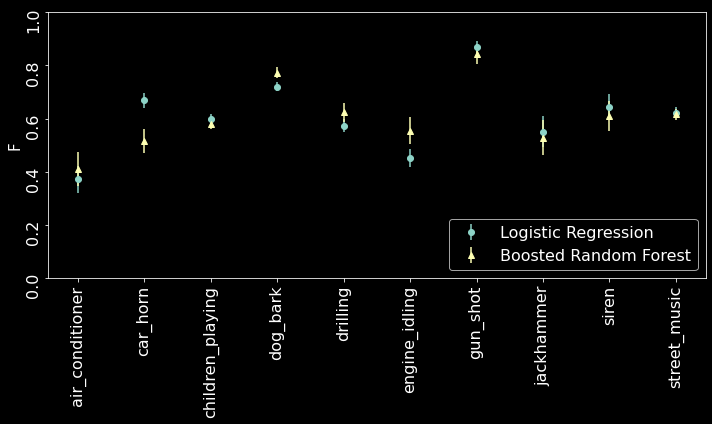

In [255]:
# Visualize KPIs across classes 

fig = plt.figure(figsize=(10,6))
ax0 = fig.add_subplot(111)


ax0.errorbar(classlabels, F_means[0], yerr = F_errs[0], label='Logistic Regression', linestyle='none', marker='o')
ax0.errorbar(classlabels, F_means[1], yerr = F_errs[1], label='Boosted Random Forest', linestyle='none', marker='^')
ax0.tick_params(rotation=90,labelsize=16)
plt.ylabel('F', fontsize=15)
plt.legend(fontsize=16,loc='lower right')
plt.ylim(0,1)
plt.tight_layout()
plt.savefig('crossval_Fs_all.png',dpi=300)
plt.show()

## Train models on the full dataset for use on new environmental sounds

Now that we have completed a thorough feature selection, classifier selection, and crossvalidation process, we can train a model on the full dataset and use it to make predictions. We will train two models, the NN and Random Forest classifiers, and will look at their use in the wild.

In [134]:
# Prepare to save model objects
import pickle

In [135]:
# Use full model data to train the model

fullX = features_df[classify_keys].values
fully = features_df['class'].values

### Train and Pickle a Full Random Forest

In [136]:
# Define the model object

fullforest = make_pipeline(RobustScaler(),RandomForestClassifier(max_depth=15, n_estimators=200,n_jobs=4))

In [137]:
# Fit the model
fullforest.fit(fullX, fully)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=15, n_estimators=200,
                                        n_jobs=4))])

In [138]:
# Save the model

with open('fullfeaturesRobustScaledRandomForest.pkl','wb') as f:
    pickle.dump(fullforest,f)

### Train and Pickle a Full logistic regression classifier

In [139]:
# Define the model object

full_log = make_pipeline(RobustScaler(), LogisticRegression(max_iter=10000, n_jobs=4))

In [140]:
# Train the model on the full data

full_log.fit(fullX, fully)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, n_jobs=4))])

In [142]:
# Save the model

with open('fullfeaturesRobustScaledlogistic.pkl','wb') as f:
    pickle.dump(full_log,f)